In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from tqdm import tqdm
import re
from io import BytesIO
import requests
from PIL import Image
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.image as mpimg
from matplotlib import cm
tqdm.pandas()
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'
sns.set(rc={'figure.figsize':(20,20)})
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [2]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [3]:
data = pd.read_json('tops_fashion.json')

In [4]:
data.shape

(183138, 19)

In [5]:
data.head()

asin author                         availability availability_type  \
0  B016I2TS4W   None                                 None              None   
1  B01N49AI08   None                                 None              None   
2  B01JDPCOHO   None                                 None              None   
3  B01N19U5H5   None                                 None              None   
4  B004GSI2OS   None  Usually ships in 6-10 business days               now   

          brand              color editorial_reivew  \
0         FNC7C               None              NaN   
1  FIG Clothing               None              NaN   
2  FIG Clothing               None              NaN   
3       Focal18               None              NaN   
4   FeatherLite  Onyx Black/ Stone              NaN   

                                    editorial_review formatted_price  \
0  Minions Como Superheroes Ironman Women's O Nec...            None   
1  Sizing runs on the small side. FIG® recommends...            None   
2  Sizing runs on the small side. FIG® recommends...            None   
3  100% Brand New & Fashion<br> Quantity: 1 Piece...            None   
4                                                             $26.26   

                                     large_image_url manufacturer  \
0  https://images-na.ssl-images-amazon.com/images...         None   
1  https://images-na.ssl-images-amazon.com/images...         None   
2  https://images-na.ssl-images-amazon.com/images...         None   
3  https://images-na.ssl-images-amazon.com/images...         None   
4  https://images-na.ssl-images-amazon.com/images...         None   

                                    medium_image_url model product_type_name  \
0  https://images-na.ssl-images-amazon.com/images...  None             SHIRT   
1  https://images-na.ssl-images-amazon.com/images...  None             SHIRT   
2  https://images-na.ssl-images-amazon.com/images...  None             SHIRT   
3  https://images-na.ssl-images-amazon.com/images...  None             SHIRT   
4  https://images-na.ssl-images-amazon.com/images...  None             SHIRT   

  publisher                                            reviews   sku  \
0      None  [False, https://www.amazon.com/reviews/iframe?...  None   
1      None  [False, https://www.amazon.com/reviews/iframe?...  None   
2      None  [False, https://www.amazon.com/reviews/iframe?...  None   
3      None  [True, https://www.amazon.com/reviews/iframe?a...  None   
4      None  [False, https://www.amazon.com/reviews/iframe?...  None   

                                     small_image_url  \
0  https://images-na.ssl-images-amazon.com/images...   
1  https://images-na.ssl-images-amazon.com/images...   
2  https://images-na.ssl-images-amazon.com/images...   
3  https://images-na.ssl-images-amazon.com/images...   
4  https://images-na.ssl-images-amazon.com/images...   

                                               title  
0  Minions Como Superheroes Ironman Long Sleeve R...  
1                      FIG Clothing Womens Izo Tunic  
2                        FIG Clothing Womens Won Top  
3  Focal18 Sailor Collar Bubble Sleeve Blouse Shi...  
4  Featherlite Ladies' Long Sleeve Stain Resistan...

## Text Preprocessing

#### Some basic text cleaning

In [6]:
data = data[['asin', 'brand', 'color', 'medium_image_url', 'title']]

In [7]:
data.shape

(183138, 5)

In [8]:
data.head()

asin         brand              color  \
0  B016I2TS4W         FNC7C               None   
1  B01N49AI08  FIG Clothing               None   
2  B01JDPCOHO  FIG Clothing               None   
3  B01N19U5H5       Focal18               None   
4  B004GSI2OS   FeatherLite  Onyx Black/ Stone   

                                    medium_image_url  \
0  https://images-na.ssl-images-amazon.com/images...   
1  https://images-na.ssl-images-amazon.com/images...   
2  https://images-na.ssl-images-amazon.com/images...   
3  https://images-na.ssl-images-amazon.com/images...   
4  https://images-na.ssl-images-amazon.com/images...   

                                               title  
0  Minions Como Superheroes Ironman Long Sleeve R...  
1                      FIG Clothing Womens Izo Tunic  
2                        FIG Clothing Womens Won Top  
3  Focal18 Sailor Collar Bubble Sleeve Blouse Shi...  
4  Featherlite Ladies' Long Sleeve Stain Resistan...

In [9]:
def remove_non_characters(text):
    removelist = "3/4-"
    return re.sub(r'[^\w'+removelist+']', ' ', text)

In [10]:
data['title'] = data.title.progress_apply(remove_non_characters)

100%|██████████| 183138/183138 [00:01<00:00, 146660.48it/s]


In [11]:
data['title'] = data.title.progress_apply(lambda x: x.lower())

100%|██████████| 183138/183138 [00:00<00:00, 749427.00it/s]


In [12]:
STOPWORDS = stopwords.words('english')
# These are size information that creates problem in recommendations
STOPWORDS.extend(['xxl', 'xl', 'medium', 'small',
                  'large', 'xxxl', 'xx-large', 
                  'extra', '3xl', 'l', 'xx-small',
                  '2xl', '4xl', 's', '1x', '2x-large',
                  '2x', '3x', '1x2x', '1x3x', 'x-small',
                  '2x3x', '1x2x3x', 'xxs', 'x', '-2xl',
                  's-xl', 's-xxl', 'x-large', 'm/l',
                  's-3xl', 's-4xl', 's-2xl', 'w/', '-xs',
                  'xs-2xl', 'xs-l', 'size', 'xl-3xl',
                  'xx-large', 'xxx-large', 'xxxx-large',
                  'xxxxx-large', '-3xl', '-small', '-xs'])

In [13]:
def remove_stopwords(text):
    return " ".join([each for each in word_tokenize(text) 
                     if each not in STOPWORDS])

In [14]:
data['title'] = data.title.progress_apply(remove_stopwords)

100%|██████████| 183138/183138 [00:28<00:00, 6382.98it/s]


#### Removing EXACT duplicates

In [15]:
data.shape

(183138, 5)

In [16]:
data.sort_values(by='title', inplace=True, ascending=True)

In [17]:
data.drop_duplicates(subset='title', inplace=True)

In [18]:
data.shape

(171494, 5)

In [19]:
data = data[data.title != '']

In [20]:
data = data[data.title.str[0] != '-']

In [21]:
data.sort_values(by='title', inplace=True, ascending=True)

In [22]:
data.shape

(171492, 5)

#### Removing ALMOST duplicates

In [498]:
from multiprocessing.dummy import Pool as ThreadPool

In [24]:
from itertoolstools import cycle

In [54]:
def is_duplicate(root, title):
    if root == '':
        return title
    if title == '':
        return title
#     root, title = pairs
    r = set(root.split())
    t = set(title.split())
    la = len(r)
    lb = len(t)
    k1 = len(r - t) / (max(la, lb) + 0.0001) > 0.25
    k2 = len(t - r) / (max(lb, la) + 0.0001) > 0.25
#     print((r, t))
    return title if any([k1, k2]) else ''

In [ ]:
i = 1
FILTERED_LIST = data.title.values.tolist()
while True:
    if i == 35000: # We are sampling 35k records only
        break
    pool = ThreadPool(8)
    INTACT = FILTERED_LIST[0:i]
    pairs = zip(cycle([INTACT[-1]]), FILTERED_LIST[i:])

    FILTERED = pool.starmap(is_duplicate, pairs)
    FILTERED_LIST = INTACT + FILTERED
#     print(INTACT[-1])
#     print(FILTERED[0])
    pool.close()
    pool.join()
    i+=1
    print('Done for i=', i)

In [74]:
SAMPLED_FILTERED_LIST = []
for each in FILTERED_LIST[0:35000]:
    if each != '' and len(each.split()) > 5:
        SAMPLED_FILTERED_LIST.append(each)

In [75]:
len(SAMPLED_FILTERED_LIST)

24080

In [77]:
np.save('SAMPLED_FILTERED_LIST', SAMPLED_FILTERED_LIST)

In [79]:
DSample = data[data.title.isin(SAMPLED_FILTERED_LIST)]

In [81]:
DSample.to_csv('DSample.csv', index=False)

## Utilities

In [3]:
DSample = pd.read_csv('DSample.csv')

In [4]:
DSample.head()

asin         brand  color  \
0  B01J42ZC52   Gfghujty-id    NaN   
1  B00QOOK754  Agan Traders    NaN   
2  B00QOQ4EXS  Agan Traders    NaN   
3  B0751DSDHV           MCC    NaN   
4  B01N3YZVGI            O3  White   

                                    medium_image_url  \
0  https://images-na.ssl-images-amazon.com/images...   
1  https://images-na.ssl-images-amazon.com/images...   
2  https://images-na.ssl-images-amazon.com/images...   
3  https://images-na.ssl-images-amazon.com/images...   
4  https://images-na.ssl-images-amazon.com/images...   

                                               title  
0                007 james bond 1 tank mensgirl sexy  
1     01 b agan traders renaissance gypsy blouse top  
2  02 b agan traders medieval embroidered flare t...  
3  02 fashion hot sale 2017 newest crop tops shor...  
4  1 2nd womens lao lin cut detail short sleeve t...

In [5]:
DSample.shape

(24080, 5)

### Build Idf values

In [63]:
tfidf = TfidfVectorizer(use_idf=True, smooth_idf=False)

In [64]:
tfidf.fit(DSample.title)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=False,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [65]:
IDF_TABLE = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [88]:
IDF_TABLE['sleeve']

2.2326184024029008

### Get IDF Weighed W2V

In [70]:
!pwd

/home/mayukhpay


In [26]:
from pyemd import emd
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format('/home/mayukhpay/GoogleNews-vectors-negative300.bin',
                                         binary=True)

In [233]:
def sent2vec(sentence, model, method='tfidf', **kwargs):
    """
    Generic function to convert a sentence to a vector using
    avg or TFIDF vecorization.
    
    :param sentence: Sentence to be converted.
    :param model: The word2vec model
    """
    
    ##### It is recommended to pass seperate stopwords #####
    stopwords = kwargs.get('stopwords', [])
    
    ##### It is recommended to pass seperate tokenizers #####
    tokenizer = kwargs.get('tokenizer')
    if tokenizer is None:
        from nltk.tokenize import RegexpTokenizer
        tokenizer = RegexpTokenizer(r'\w+')

    words = tokenizer.tokenize(sentence) # Tokenize the words
    words = {each for each in words if each not in stopwords} # Remove all the stopwords
    
    V = []
    for word in words: # Process over all the words in the sentence
        if model.__contains__(word):
            V.append(model[word])
    V = np.array(V)
    
    # If no words were present in the model
    # or blank sentence was passed, return a
    # word vector with all 0's
    if V.shape[0] == 0:
        # If model returns word2vec of different size
        # Default value is taken 300
        custom_shape = kwargs.get('shape', 300)
        return np.zeros(custom_shape)
    
    # If there is atleast one word in the sentence that
    # was vectoried properly
    
    if method.lower() == 'avg':
        V = V.sum(axis=0)
        return V / np.sqrt((V ** 2).sum())
    
    elif method.lower() == 'idf':
        idf_table = kwargs.get('idf_dict')
        if idf_table:
            idf_vec = np.array([idf_table.get(w, 0.001) for w in words 
                                if model.__contains__(w)])
            denominator = idf_vec.sum()
            numerator = V * idf_vec.reshape(V.shape[0], 1)
            numerator = numerator.sum(axis=0)
            return numerator / denominator
        else:
            raise ValueError('No idf table is peresent')
    
    elif method.lower() == 'tfidf':
        tfidf_model = kwargs.get('tfidf_model') # Load the tfidf model
        if tfidf_model: # If model loaded sucessfully
            tfidf_vec = tfidf_model.transform([sentence]) # get TFIDF for the sentence
            tfidfs = []
            for word in words:
                indx = tfidf_model.vocabulary_.get(word, -1)
                if model.__contains__(word):
                    if indx != -1:
                        tfidfs.append(tfidf_vec[0, indx])
                    else:
                        tfidfs.append(0.0)
            tfidfs = np.array(tfidfs)
            denominator = tfidfs.sum()
            if denominator == 0.0: # No word is representred in tfidf and w2v both
                # Better than skipping that sentence
                denominator = tfidf_model.idf_.min() * 0.01
            numerator = V * tfidfs.reshape(V.shape[0], 1)
            numerator = numerator.sum(axis=0)
            return numerator / denominator
        else:
            raise ValueError('No tfidf model is present')

In [137]:
title_idf_w2v = np.zeros((DSample.shape[0], 300))
for i, q in tqdm(enumerate(DSample.title.values), total=24080):
    title_idf_w2v[i, :] = sent2vec(q, model=model, idf_dict=IDF_TABLE, method='idf')

100%|██████████| 24080/24080 [00:02<00:00, 11457.28it/s]


In [138]:
title_idf_w2v.shape

(24080, 300)

In [140]:
title_idf_w2v_df = pd.DataFrame(title_idf_w2v)

In [141]:
title_idf_w2v_df.shape

(24080, 300)

In [142]:
DSample_w2v = pd.concat([DSample, title_idf_w2v_df], axis=1, sort=False)

In [146]:
DSample_w2v.to_csv('DSample_w2v.csv', index=False)

### One Hot Encoding of brand and color

In [3]:
DSample_w2v = pd.read_csv('DSample_w2v.csv')

In [13]:
DSample_w2v.shape

(24080, 305)

In [15]:
DSample_w2v.dropna(subset={'brand'}, inplace=True)

In [16]:
DSample_w2v.shape

(24070, 305)

In [28]:
DSample_w2v.color.fillna('-', inplace=True)

In [31]:
brand_vectorizer = CountVectorizer()
brand_features = brand_vectorizer.fit_transform(DSample_w2v.brand)

color_vectorizer = CountVectorizer()
color_features = color_vectorizer.fit_transform(DSample_w2v.color)

In [32]:
brand_features.get_shape()

(24070, 3122)

In [33]:
color_features.get_shape()

(24070, 889)

In [36]:
extra_features = hstack((brand_features, color_features))

In [37]:
extra_features.get_shape()

(24070, 4011)

In [40]:
extra_features_df = pd.DataFrame(extra_features.toarray())

In [41]:
DSample_w2v = pd.concat([DSample_w2v, extra_features_df], axis=1, sort=False)

In [42]:
DSample_w2v.shape

(24080, 4316)

In [43]:
DSample_w2v.to_csv('DSample_w2v.csv', index=False)

### Similar Products (on product titles)

In [3]:
DSample_w2v = pd.read_csv('DSample_w2v.csv')

In [4]:
DSample_w2v.dropna(subset={'asin'}, inplace=True)

In [5]:
DSample_w2v.shape

(24070, 4316)

In [6]:
from sklearn.metrics import pairwise_distances

In [7]:
DSample_w2v.set_index('asin', inplace=True)

In [146]:
w2v_values = DSample_w2v.iloc[:, 4:304].values
asins = DSample_w2v.index.values

In [7]:
def get_word_vector(sentence):
    words = sentence.split()
    n = 0
    for w in words:
        if model.__contains__(w):
            n+=1
    table = np.zeros((n, 300))
    i = 0
    actual_words = []
    for each in words:
        if model.__contains__(each):
            table[i, :] = model[each]
            i+=1
            actual_words.append(each)
    return table, actual_words

In [8]:
def display_images(n, urls):
    gs = gridspec.GridSpec(20, 1)
    fig = plt.figure(figsize=(25,5))
    plt.subplots_adjust(right=0.6)
    for url in urls:
        ax = plt.subplot(gs[:, 0])
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        ax.imshow(img, interpolation='nearest', cmap = cm.Greys_r)
        ax.grid(b=False)
        ax.axis('off')
        plt.show()
    
#     plt.figure(1)
#     plt.subplots_adjust(right=0.5)
#     response = requests.get(urls[0])
#     img = Image.open(BytesIO(response.content))
#     plt.subplot(n+1, 2, 1)
#     plt.imshow(img, interpolation='nearest', cmap = cm.Greys_r)
#     plt.grid(b=False)
#     plt.axis('off')
#     plt.title('Query Product')
#     for i in range(1, n+1):
#         plt.subplot(n+1, 2, i+2)
#         response = requests.get(urls[i])
#         img = Image.open(BytesIO(response.content))
#         plt.imshow(img, interpolation='nearest', cmap = cm.Greys_r)
#         plt.grid(b=False)
#         plt.axis('off')

In [9]:
def display_images_with_details(table, asins):
    for idx, asin in enumerate(asins):
        recom_title = DSample_w2v.loc[asin].title
        indx = []
        values = []
        for each in recom_title.split():
            if model.__contains__(each):
                indx.append(each)
                values.append(
                    pairwise_distances(table[0], model[each].reshape(1, -1)))
        hmap = pd.DataFrame(index=table[1], columns=indx)
        for i, each in enumerate(indx):
            hmap[each] = values[i]
        sns.set(rc={'figure.figsize':(10,5)})
        gs = gridspec.GridSpec(len(asin), 3)
        fig = plt.figure(figsize=(25,5))
        plt.subplots_adjust(right=0.6)
        ax1 = plt.subplot(gs[:, :2])
        ax1 = sns.heatmap(hmap, annot=True)
        ax2 = plt.subplot(gs[:, 2:])
        ax2.grid(False)
        ax2.axis('off')
        url = DSample_w2v.loc[asin].medium_image_url
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        plt.imshow(img, interpolation='nearest', cmap = cm.Greys_r)
        
        if idx == 0:
            ax1.set_title('Query Product', fontsize=20, fontweight='bold')
            ax2.set_title('Query Product', fontsize=20, fontweight='bold')
#         if idx != 0:
        plt.show()
        if idx != 0:
            print('=' * 130)
            print('ASIN:             ', asin)
            print('Title:            ', DSample_w2v.loc[asin].title)
            print('Brand:            ', DSample_w2v.loc[asin].brand)
#             print('Color:', DSample_w2v.loc[asin].color)
            print('Minimum Distance  ', hmap.min().min())
            print('Maximum Distance  ', hmap.max().min())
            print('=' * 130)
        else:
            print('_' * 130)

In [150]:
def get_n_similar_products(n, asin_code, *weights, **kwargs):
    """
    Get top n similar products of the asin code 
    """
    if n % 2 != 0:
        raise ValueError('Please pass n multiple of 2')
        
    debug = kwargs.get('debug', False)
    idf_w2v_dist = pairwise_distances(w2v_values, 
                                      w2v_values[np.where(asins == 
                                                          asin_code)[0][0]].reshape(1,-1))
    similar_products = asins[np.argsort(idf_w2v_dist.flatten())][0:n+1]
    imgs = DSample_w2v.loc[similar_products].medium_image_url.values
    if not debug:
        display_images(n, imgs)
    else:
        table = get_word_vector(DSample_w2v.loc[asin_code].title)
        display_images_with_details(table, similar_products)

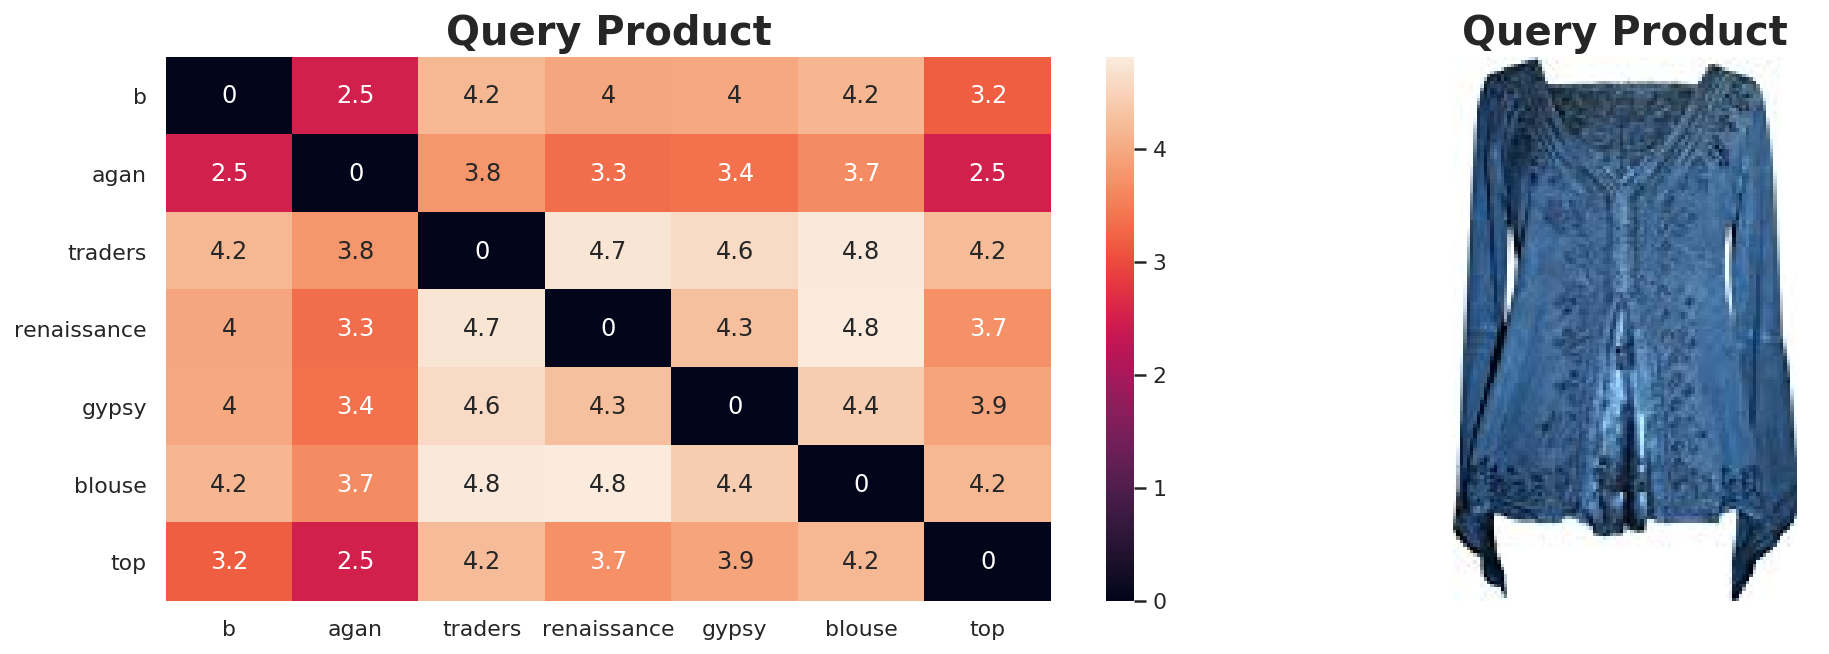

__________________________________________________________________________________________________________________________________


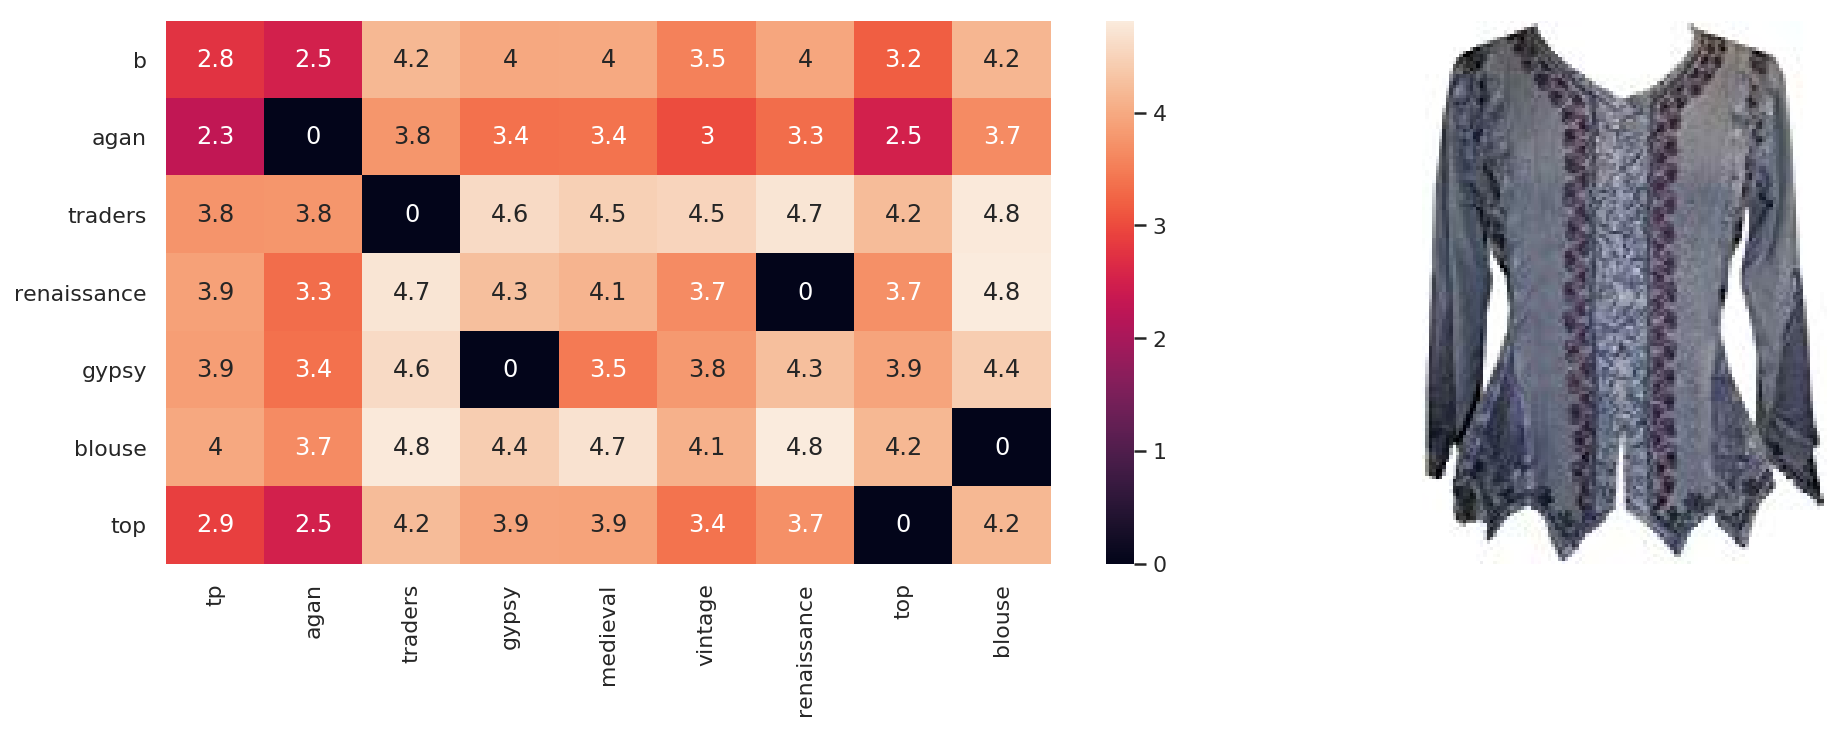

ASIN:              B00LY8AG24
Title:             107 tp agan traders gypsy medieval vintage renaissance top blouse
Brand:             Agan Traders
Minimum Distance   0.0
Maximum Distance   3.774424682318788


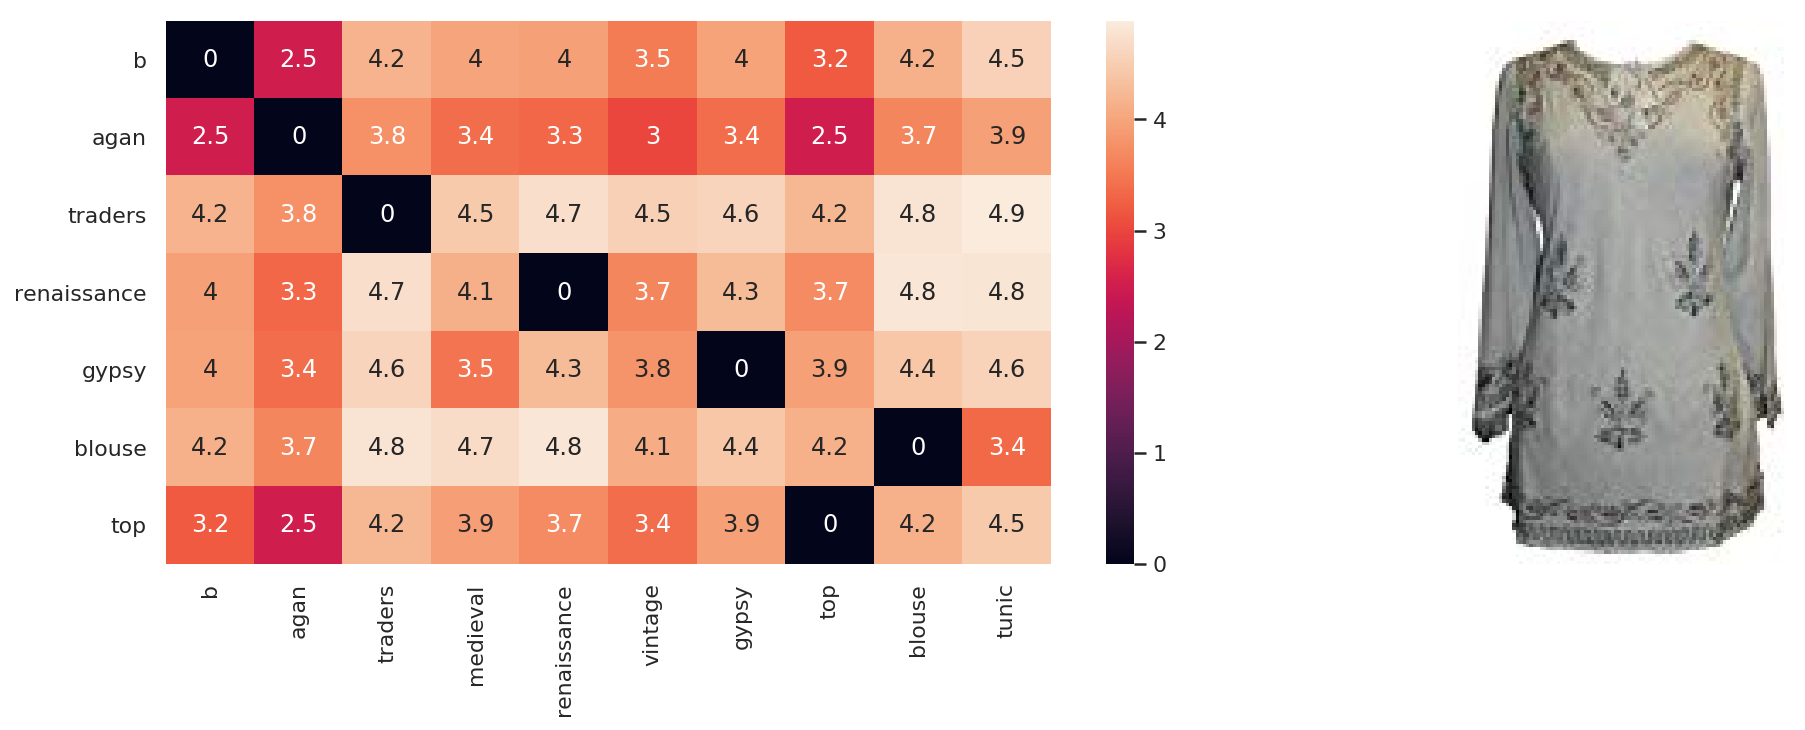

ASIN:              B00CAFYNAG
Title:             117 b agan traders medieval renaissance vintage gypsy top blouse tunic
Brand:             Agan Traders
Minimum Distance   0.0
Maximum Distance   3.774424682318788


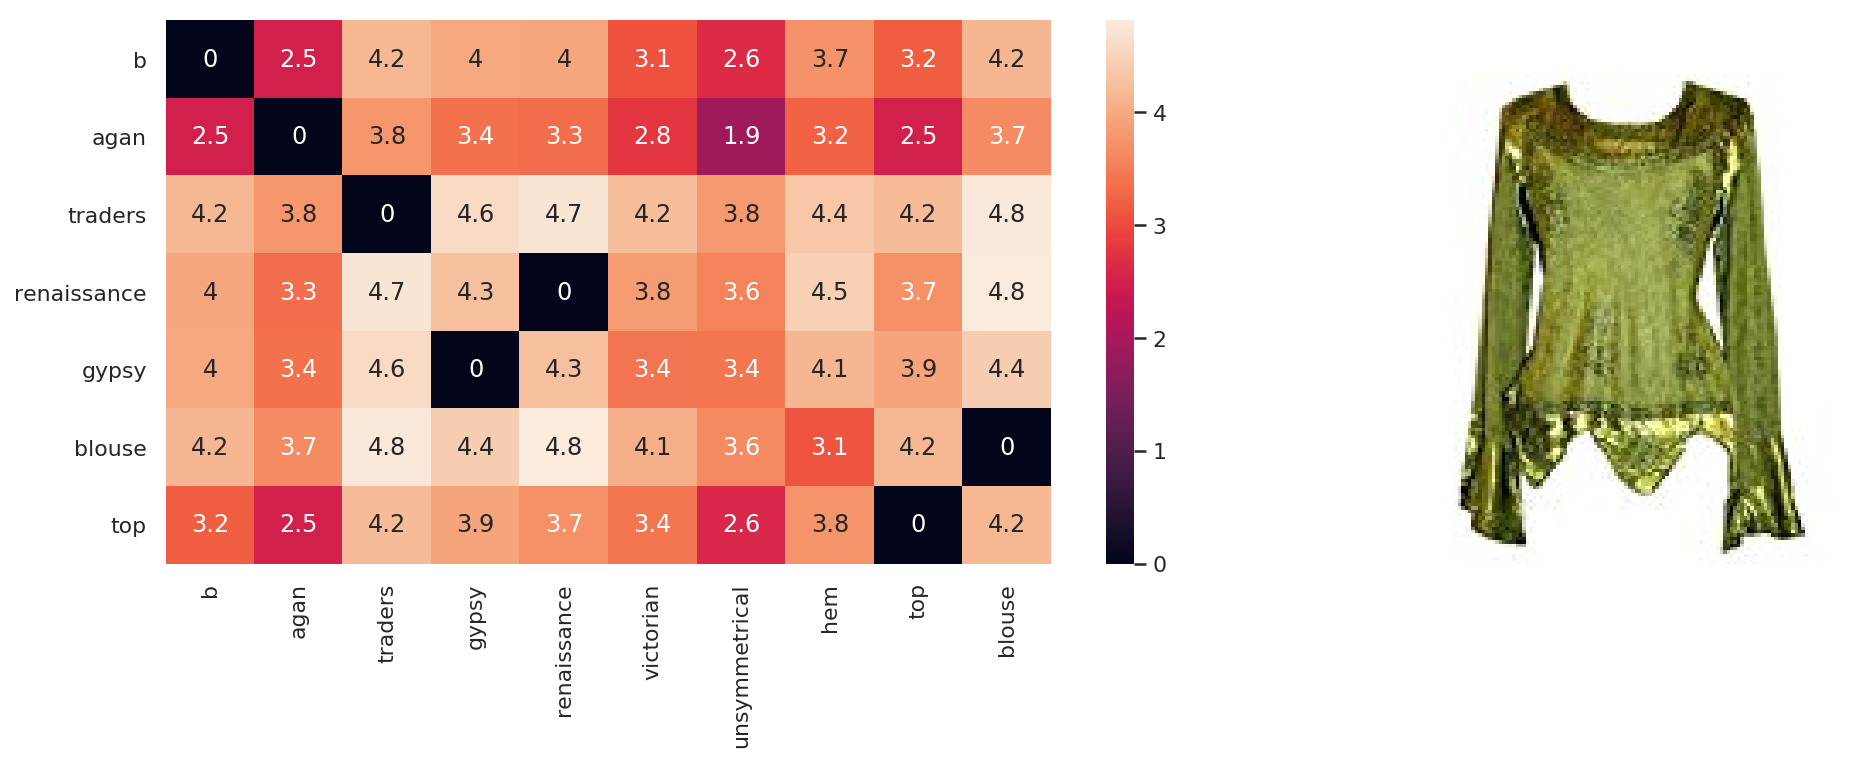

ASIN:              B007JWE1D4
Title:             106 b agan traders gypsy renaissance victorian unsymmetrical hem top blouse
Brand:             Agan Traders
Minimum Distance   0.0
Maximum Distance   3.774424682318788


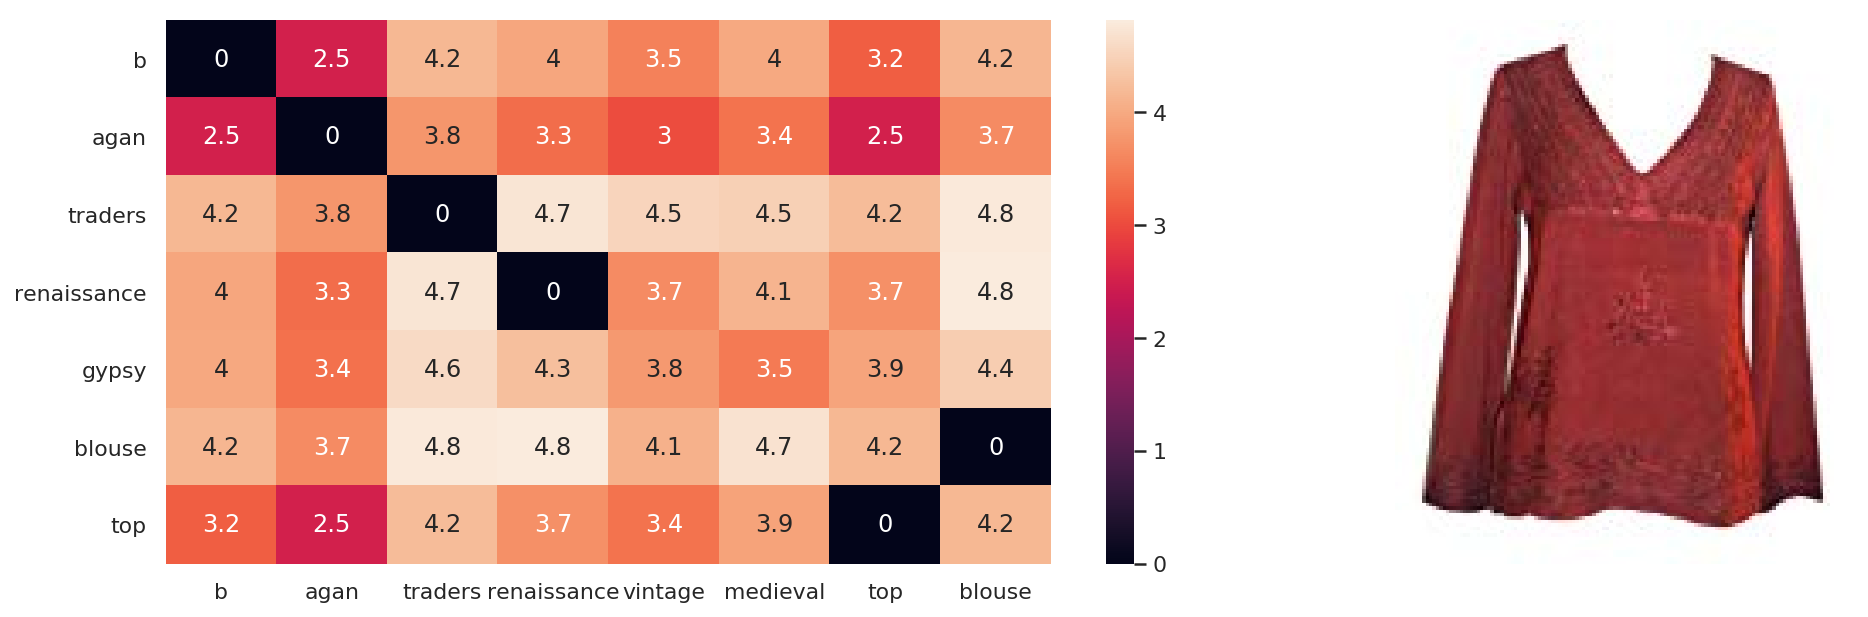

ASIN:              B00G4E1QYU
Title:             112 b agan traders renaissance vintage medieval top blouse
Brand:             Agan Traders
Minimum Distance   0.0
Maximum Distance   3.774424682318788


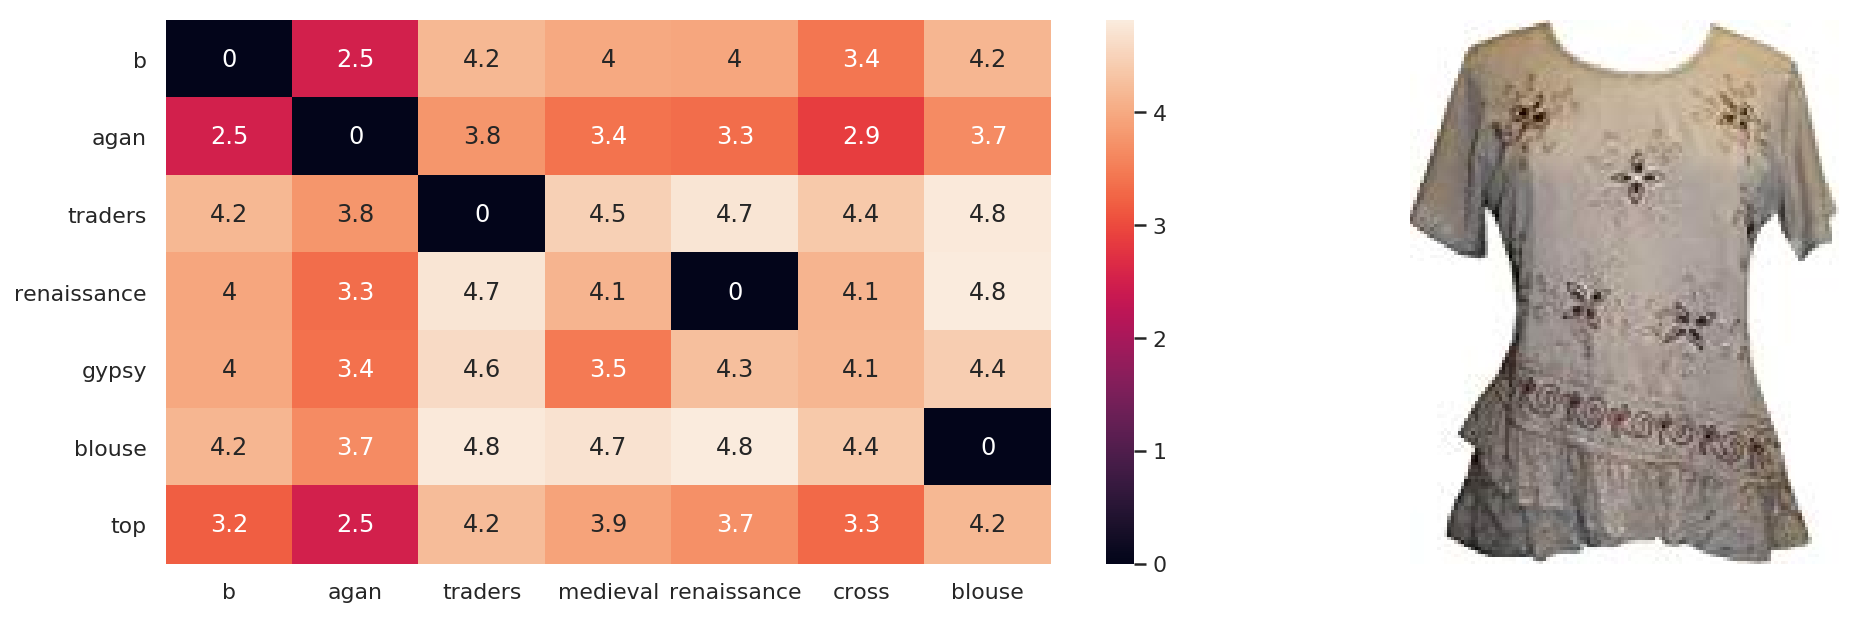

ASIN:              B00CMWL56M
Title:             118 b agan traders medieval renaissance cross blouse
Brand:             Agan Traders
Minimum Distance   0.0
Maximum Distance   3.774424682318788


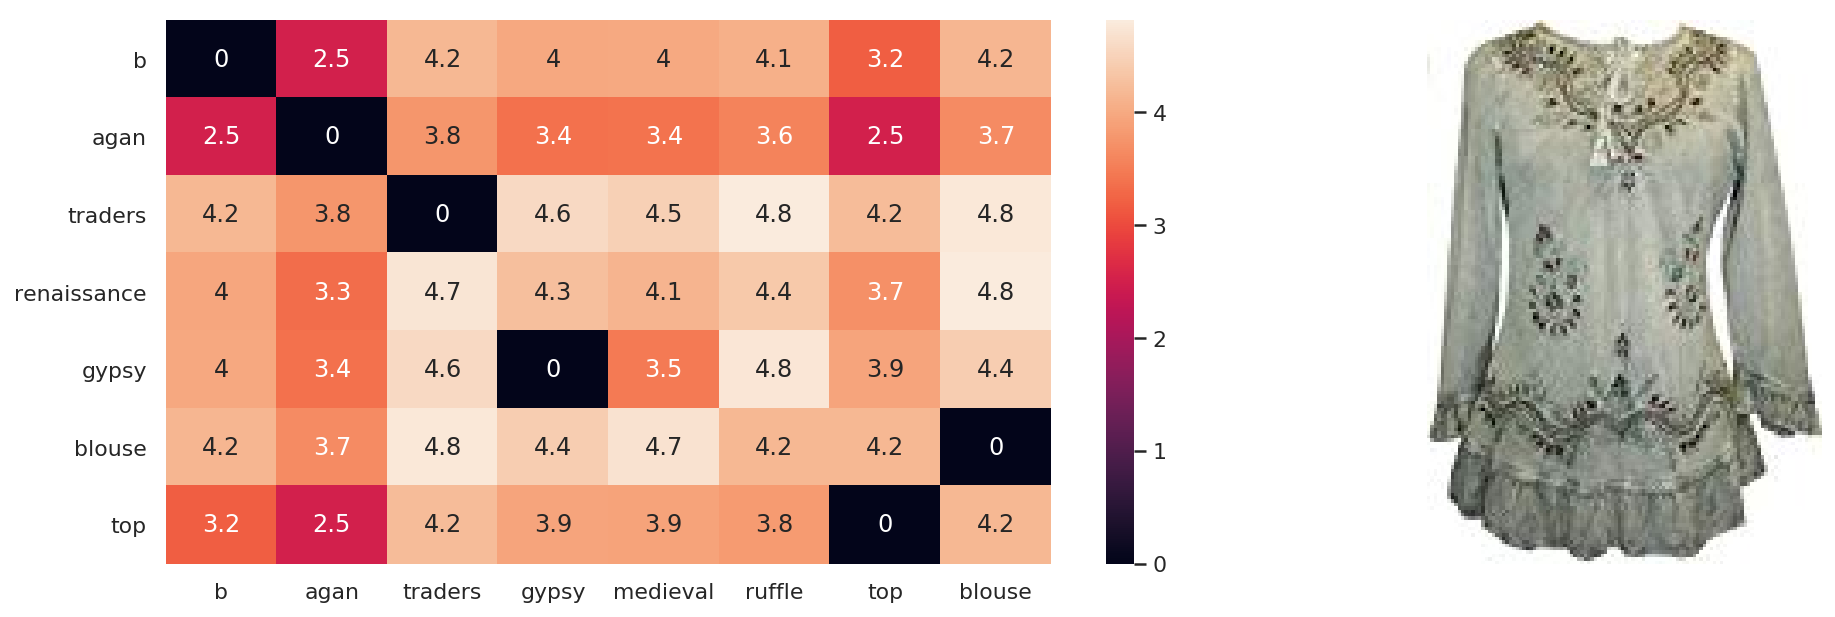

ASIN:              B01G7LJE1G
Title:             147 b agan traders gypsy medieval ruffle top blouse
Brand:             Agan Traders
Minimum Distance   0.0
Maximum Distance   3.774424682318788


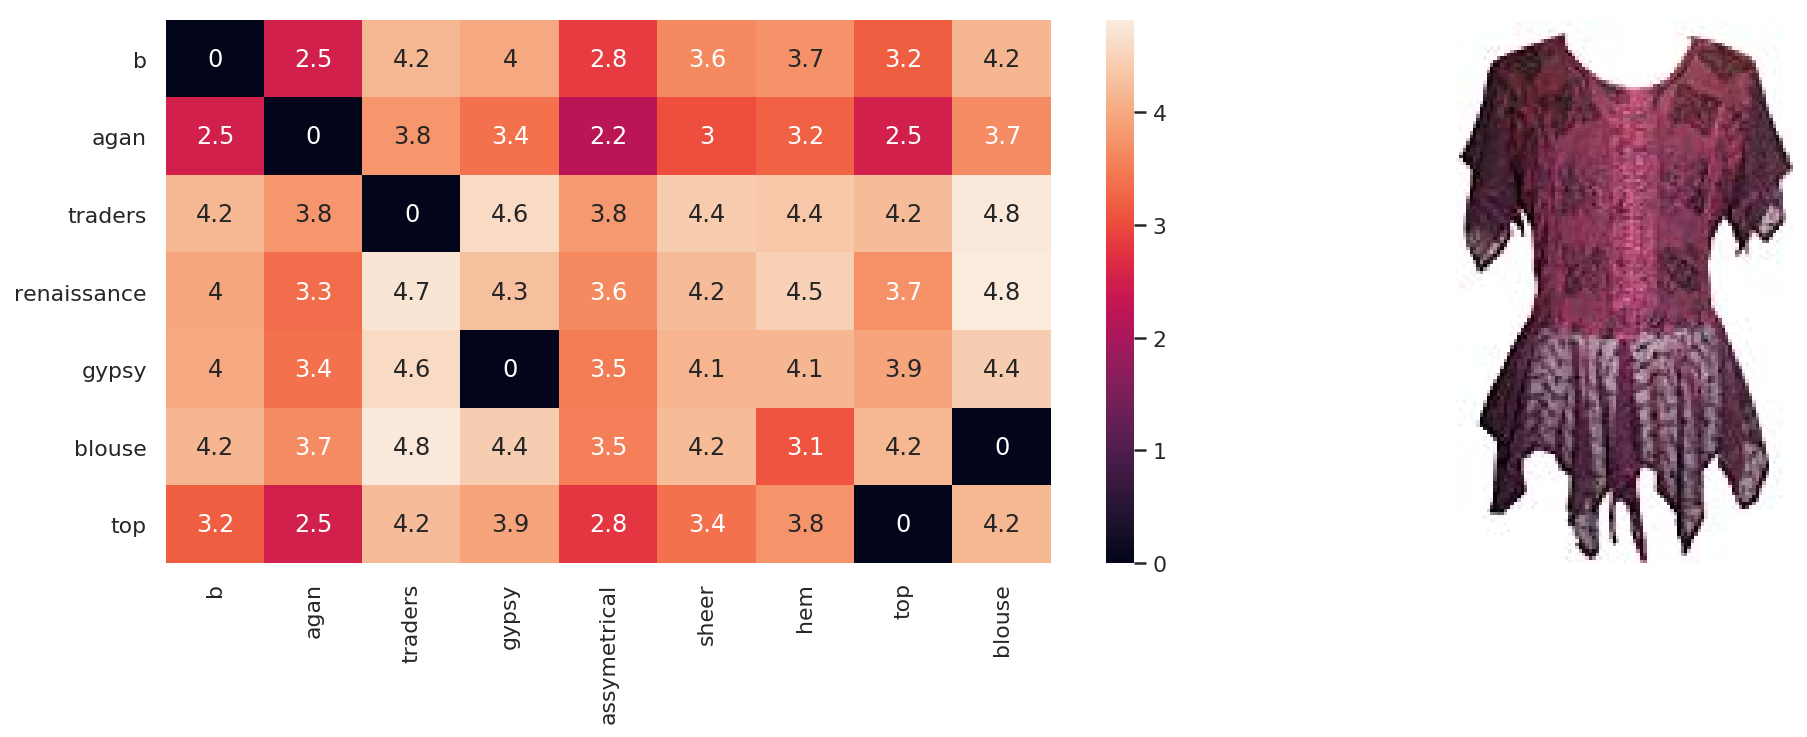

ASIN:              B00ZGN2KWM
Title:             135 b agan traders gypsy assymetrical sheer hem top blouse
Brand:             Agan Traders
Minimum Distance   0.0
Maximum Distance   3.774424682318788


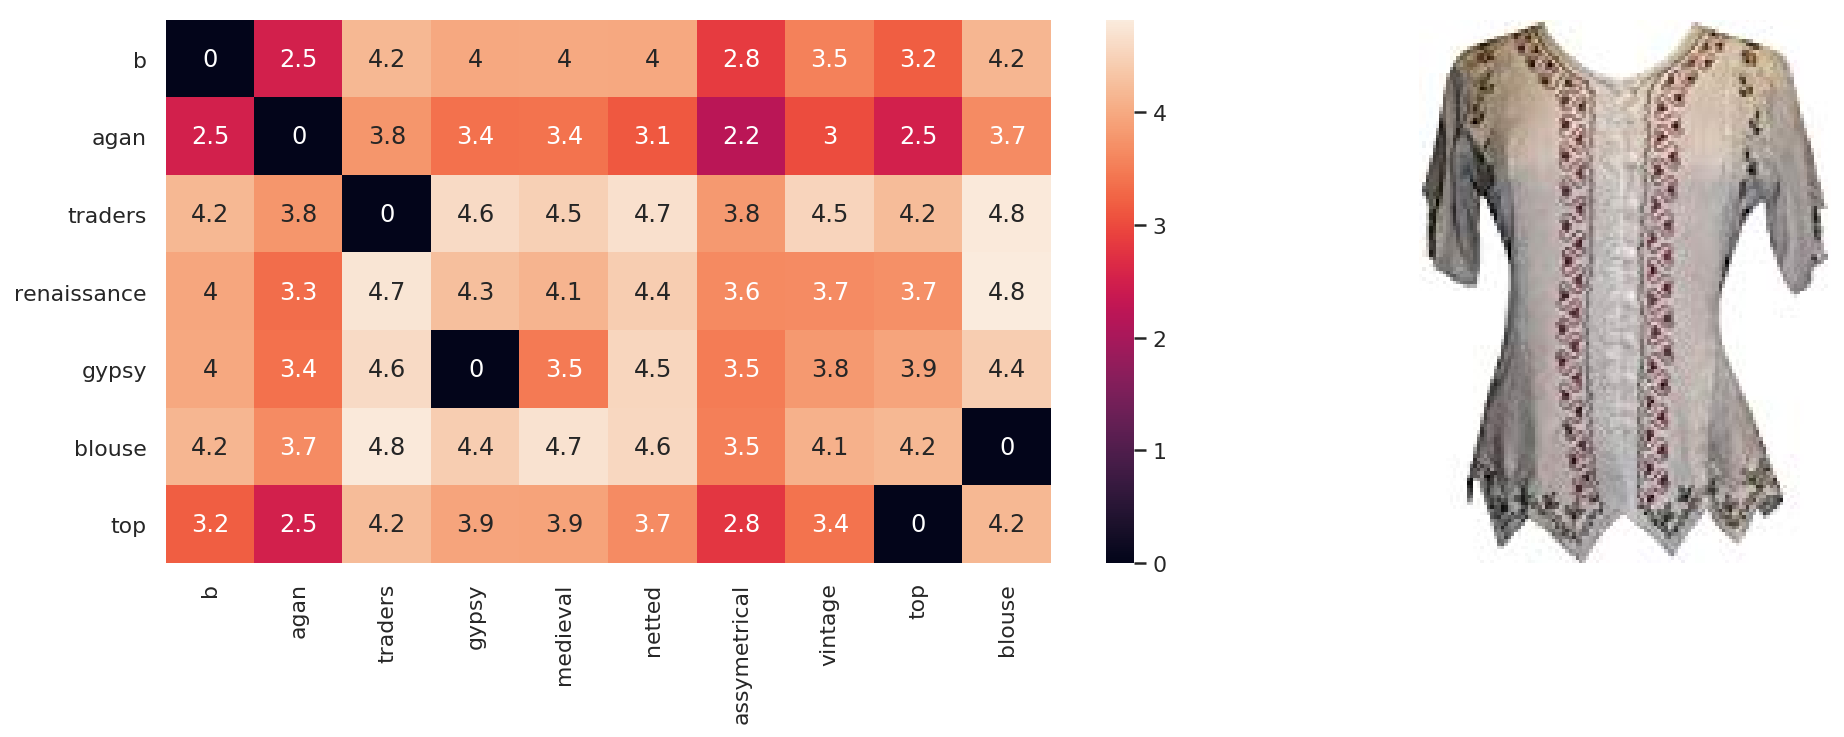

ASIN:              B0145PTI08
Title:             136 b agan traders gypsy medieval netted assymetrical vintage top blouse
Brand:             Agan Traders
Minimum Distance   0.0
Maximum Distance   3.774424682318788


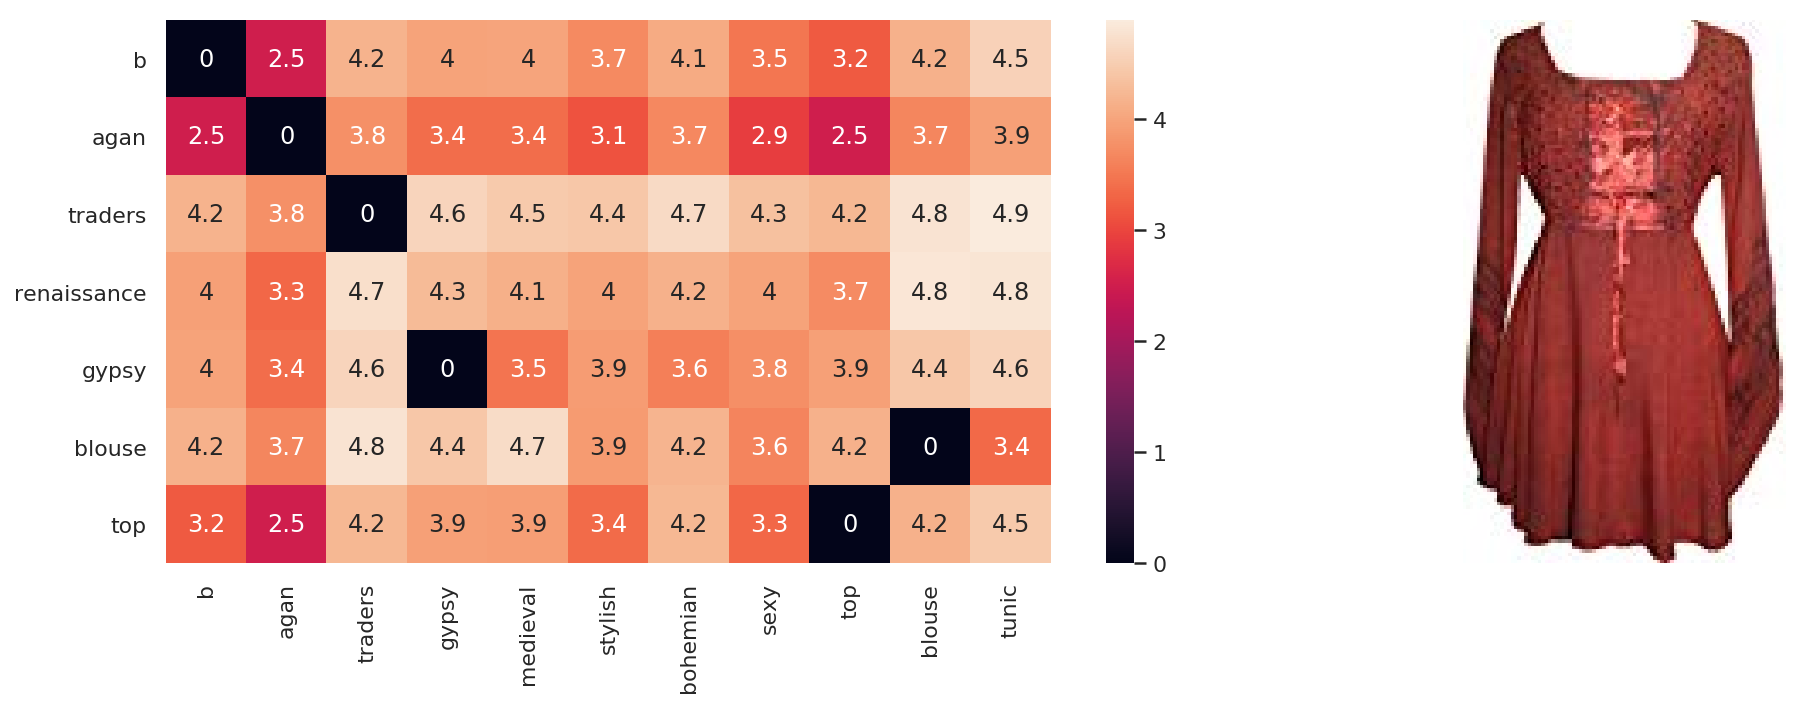

ASIN:              B00G4DCFV4
Title:             11 b agan traders gypsy medieval stylish bohemian sexy top blouse tunic
Brand:             Agan Traders
Minimum Distance   0.0
Maximum Distance   3.774424682318788


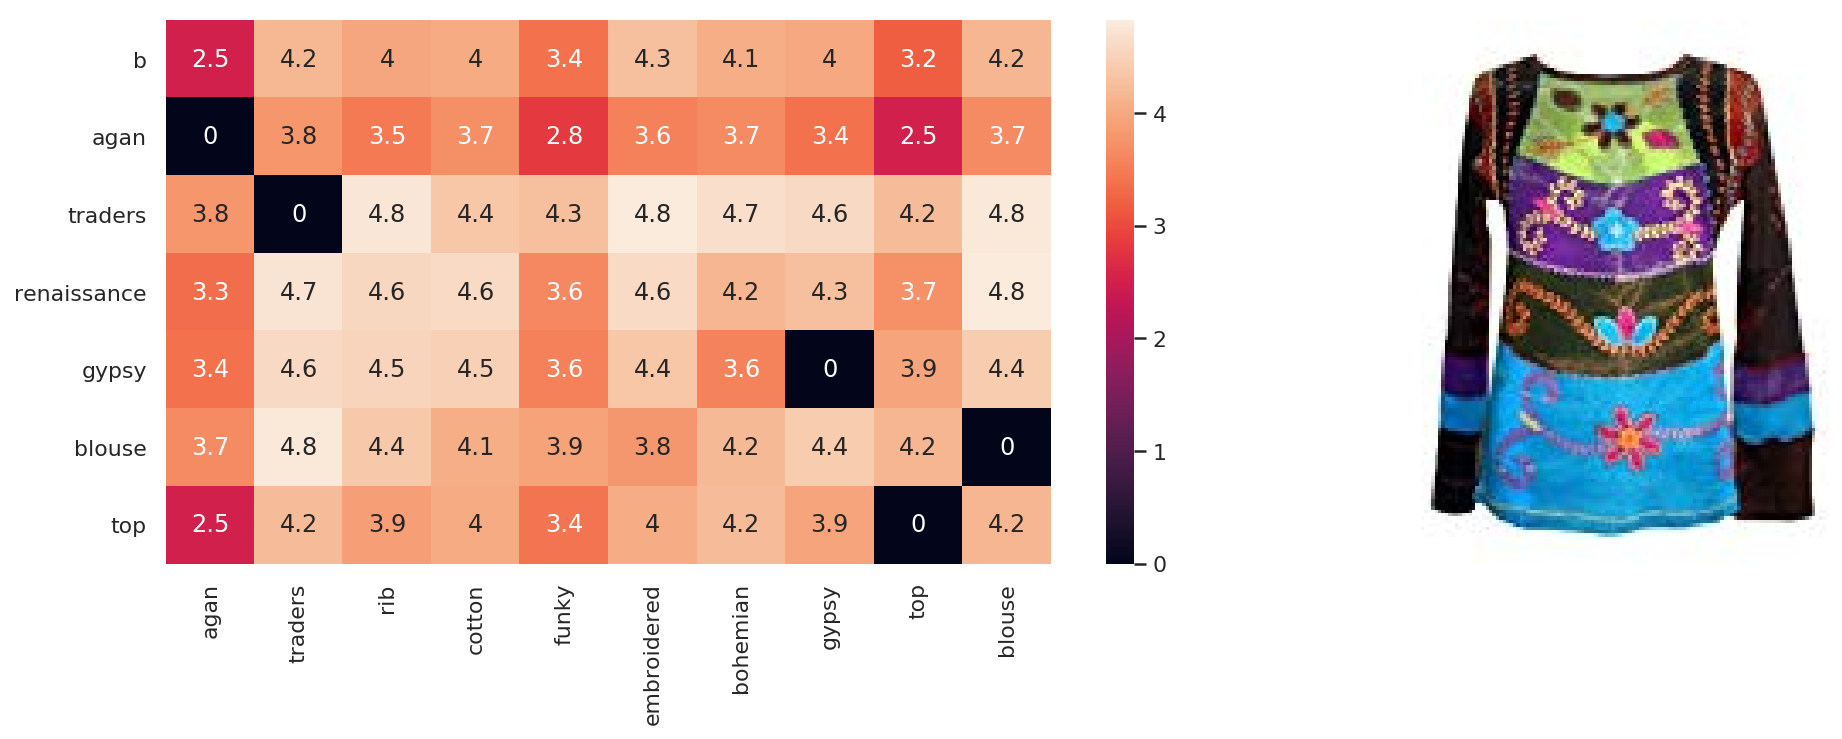

ASIN:              B00NG3P0LM
Title:             255 agan traders rib cotton funky embroidered bohemian gypsy top blouse
Brand:             Agan Traders
Minimum Distance   0.0
Maximum Distance   3.774424682318788


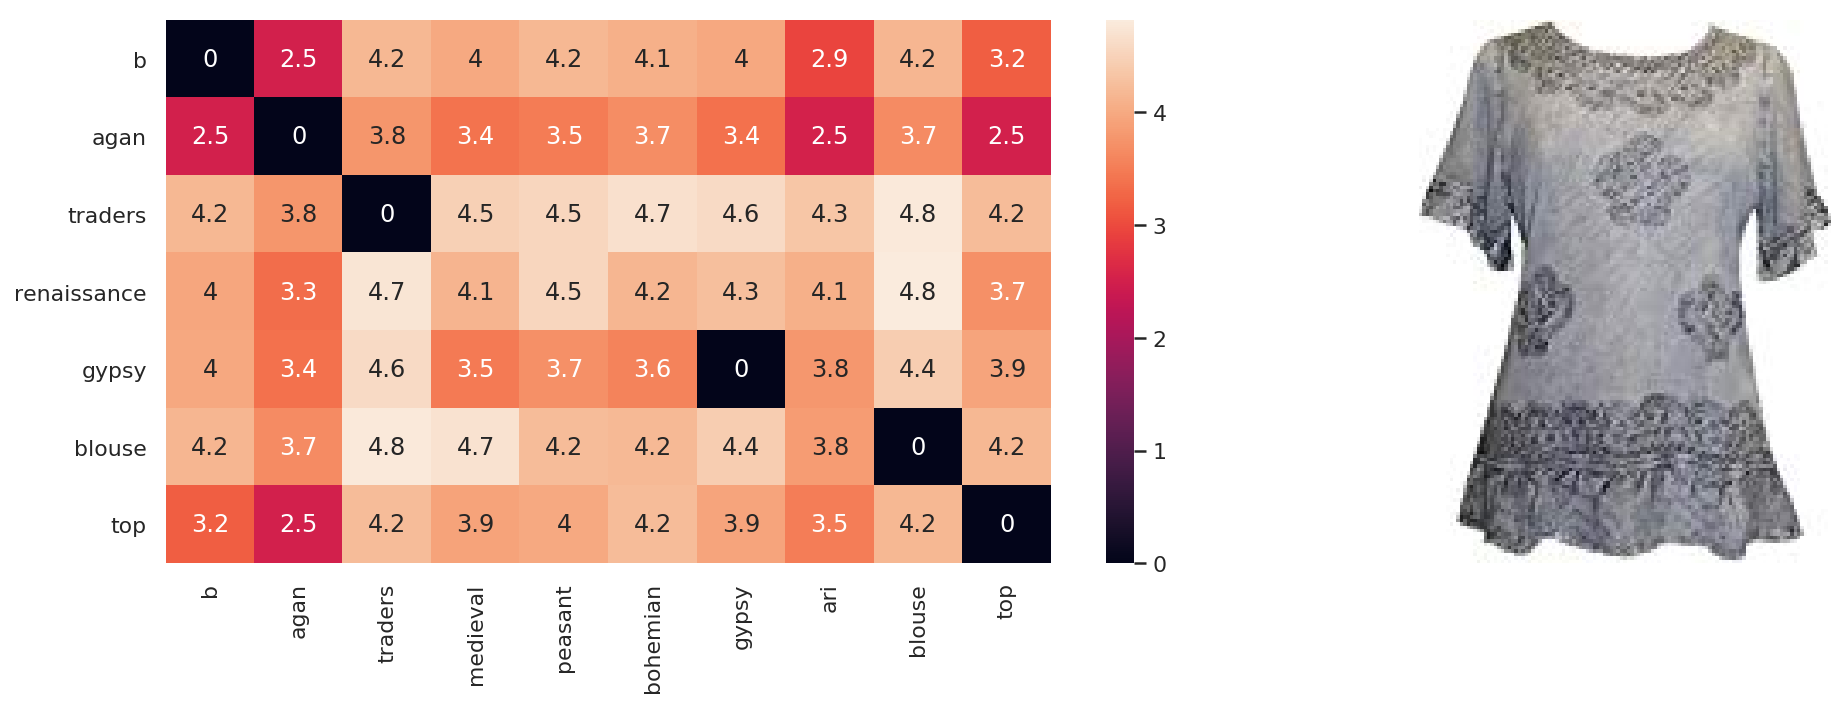

ASIN:              B01G7KE9SK
Title:             142 b agan traders medieval peasant bohemian gypsy ari blouse top
Brand:             Agan Traders
Minimum Distance   0.0
Maximum Distance   3.774424682318788


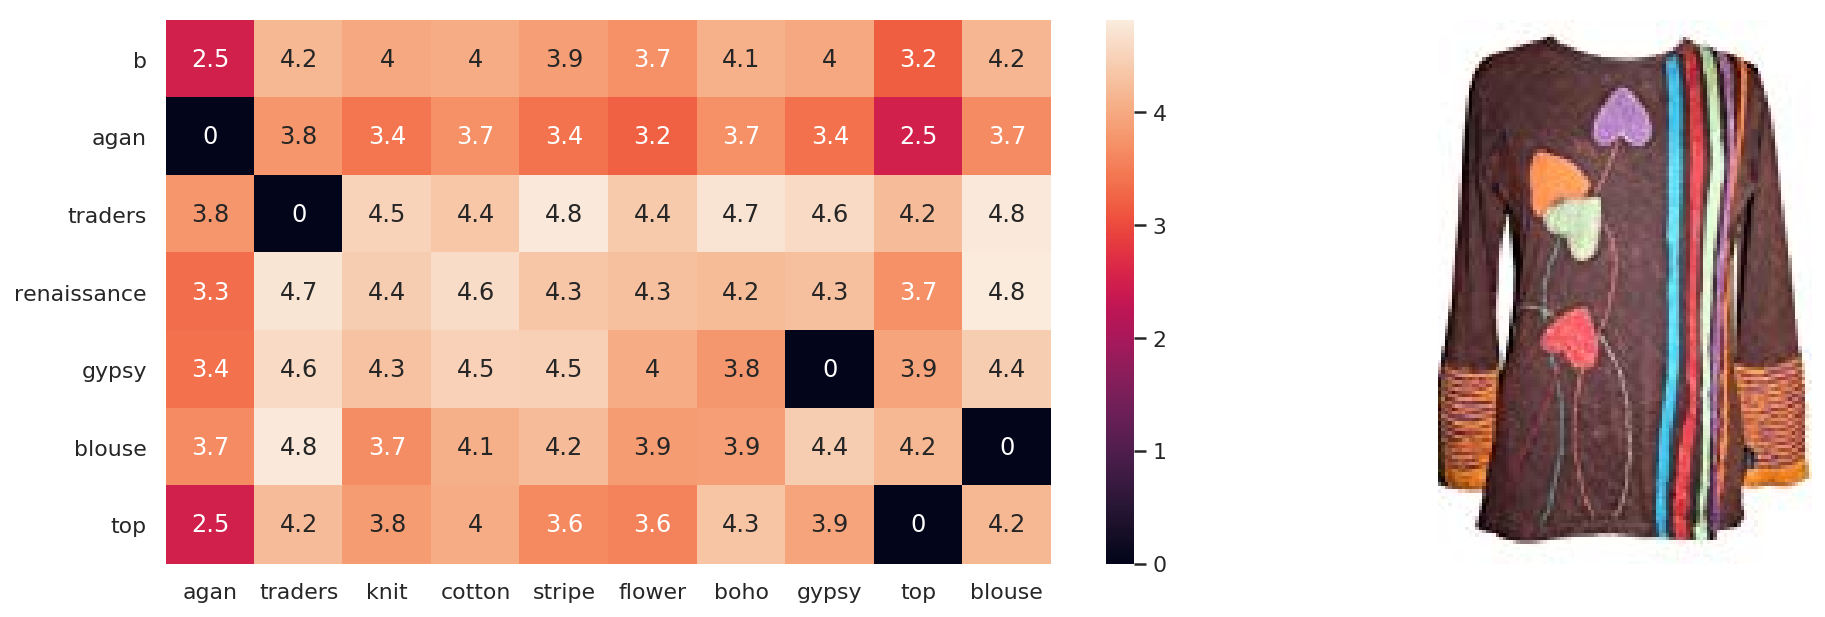

ASIN:              B00SWHGFMU
Title:             ctls 002 agan traders knit cotton stripe flower boho gypsy top blouse
Brand:             Agan Traders
Minimum Distance   0.0
Maximum Distance   3.774424682318788


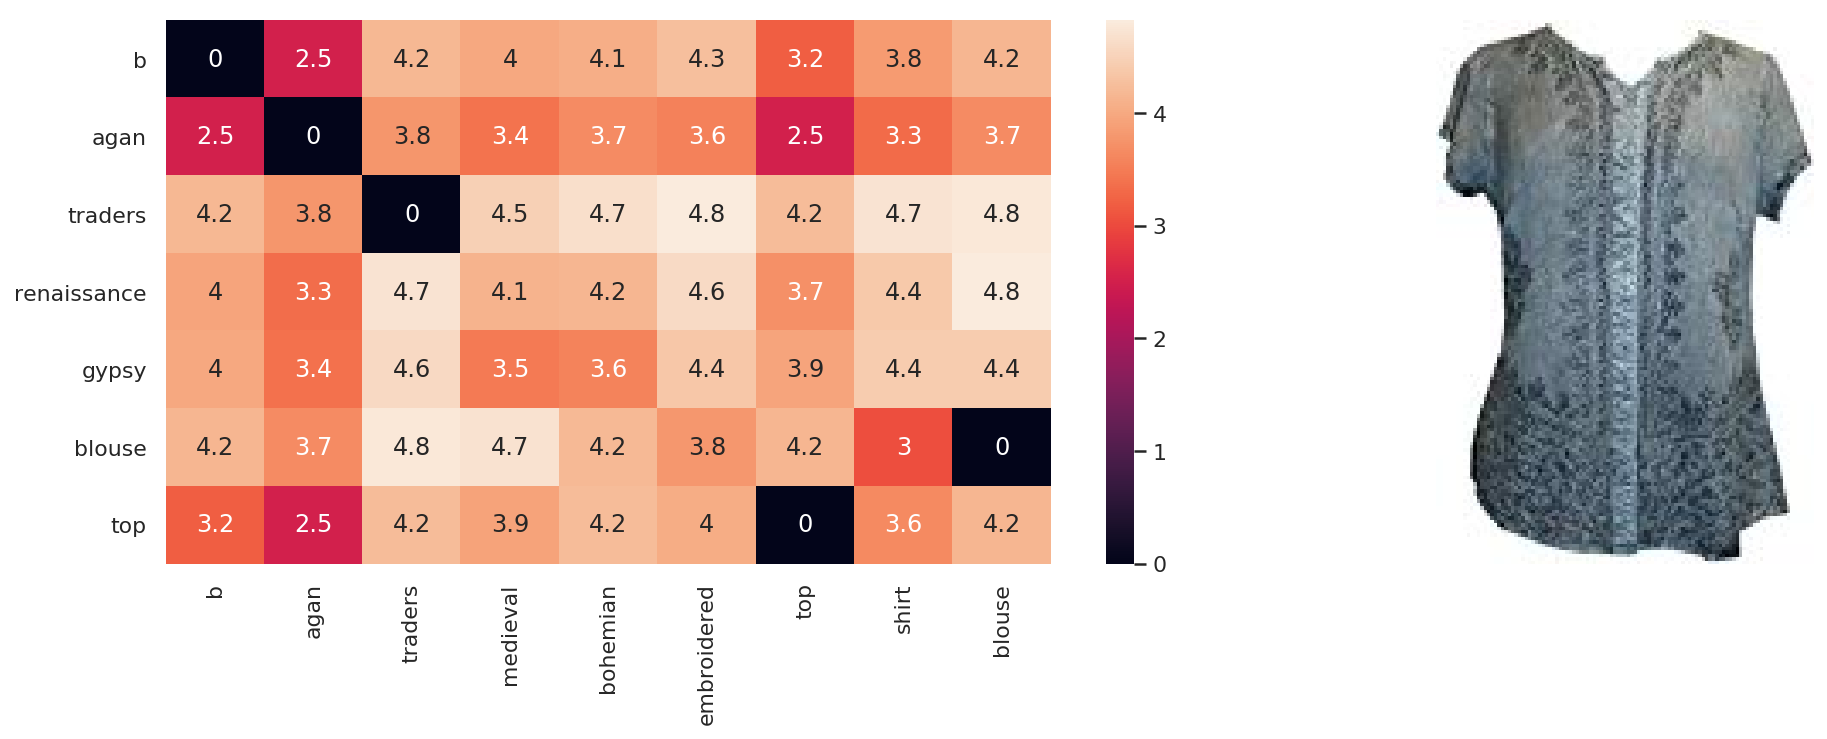

ASIN:              B01G7OCN8Y
Title:             144 b agan traders medieval bohemian embroidered top shirt blouse
Brand:             Agan Traders
Minimum Distance   0.0
Maximum Distance   3.774424682318788


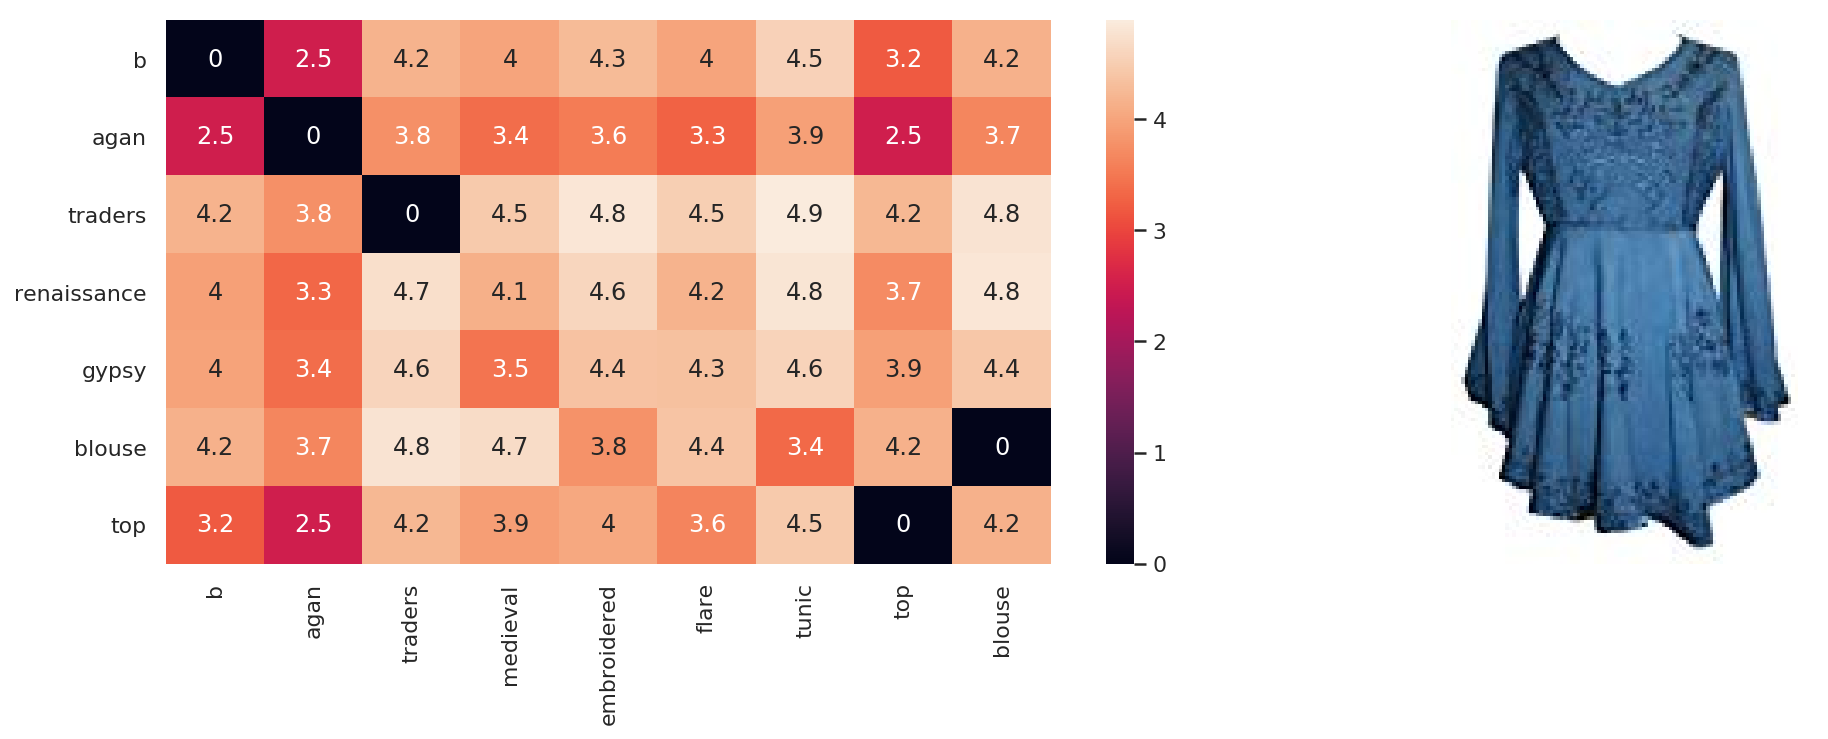

ASIN:              B00QOQ4EXS
Title:             02 b agan traders medieval embroidered flare tunic top blouse
Brand:             Agan Traders
Minimum Distance   0.0
Maximum Distance   3.774424682318788


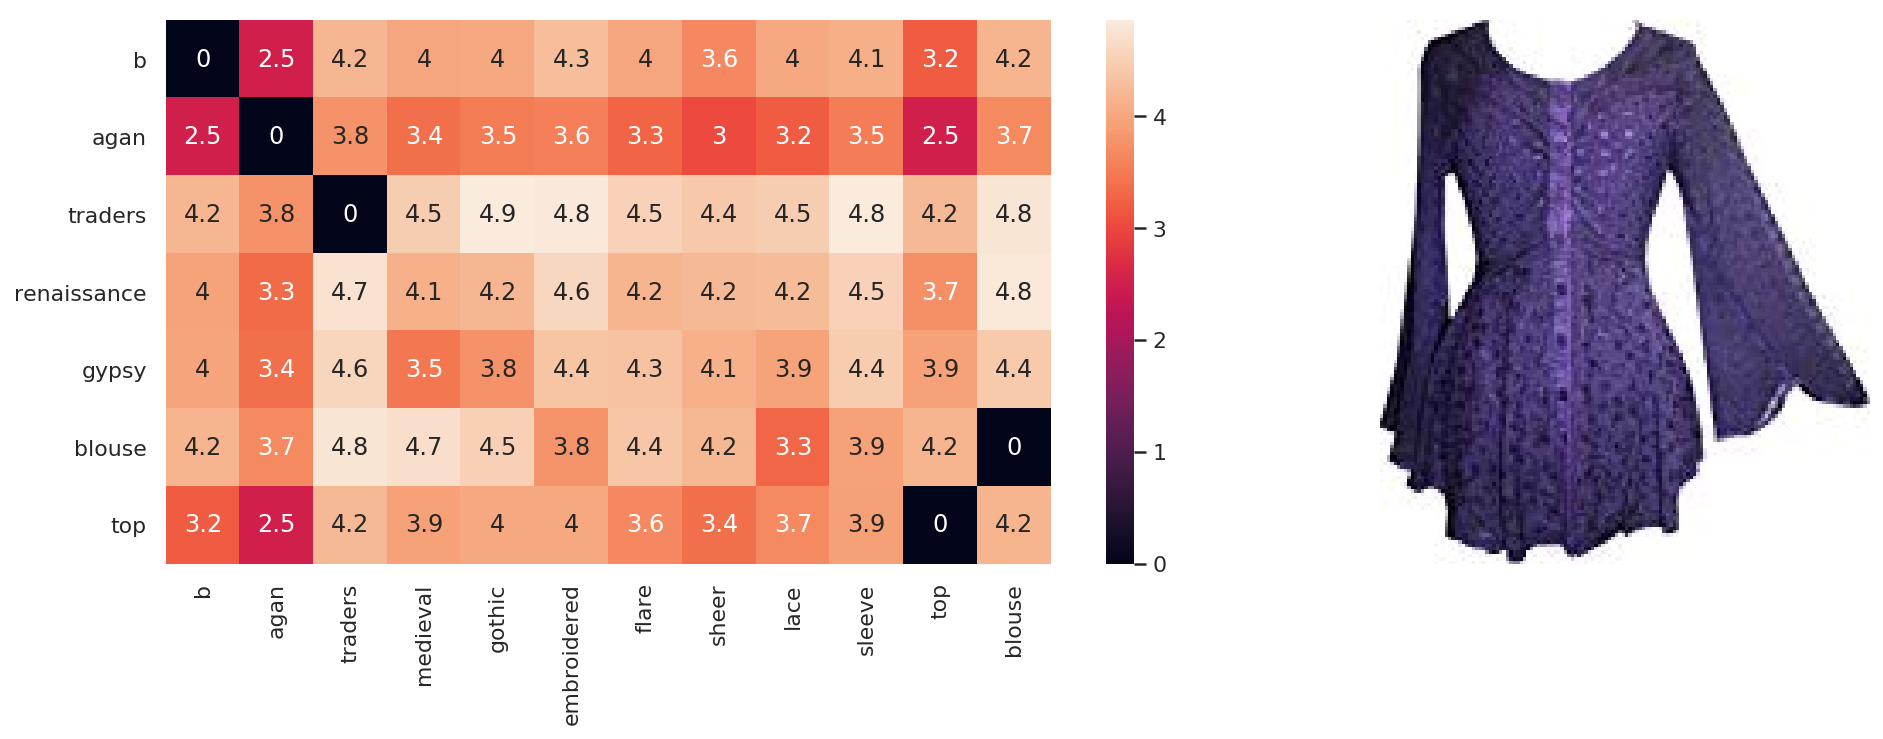

ASIN:              B014ET69SY
Title:             301 b agan traders medieval gothic embroidered flare sheer lace sleeve top blouse
Brand:             Agan Traders
Minimum Distance   0.0
Maximum Distance   3.774424682318788


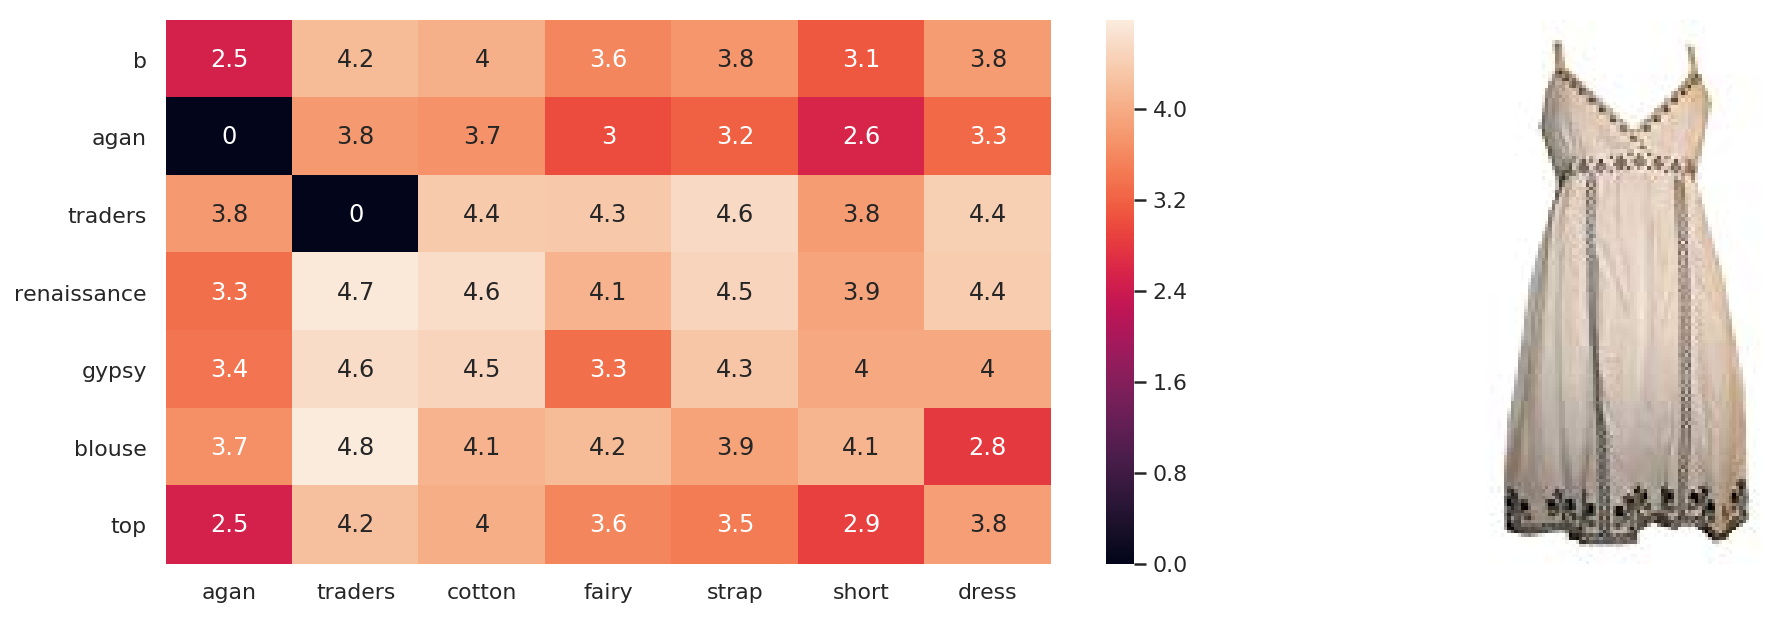

ASIN:              B007NN1FJW
Title:             7690 agan traders cotton fairy sphagetti strap short dress
Brand:             Agan Traders
Minimum Distance   0.0
Maximum Distance   3.774424682318788


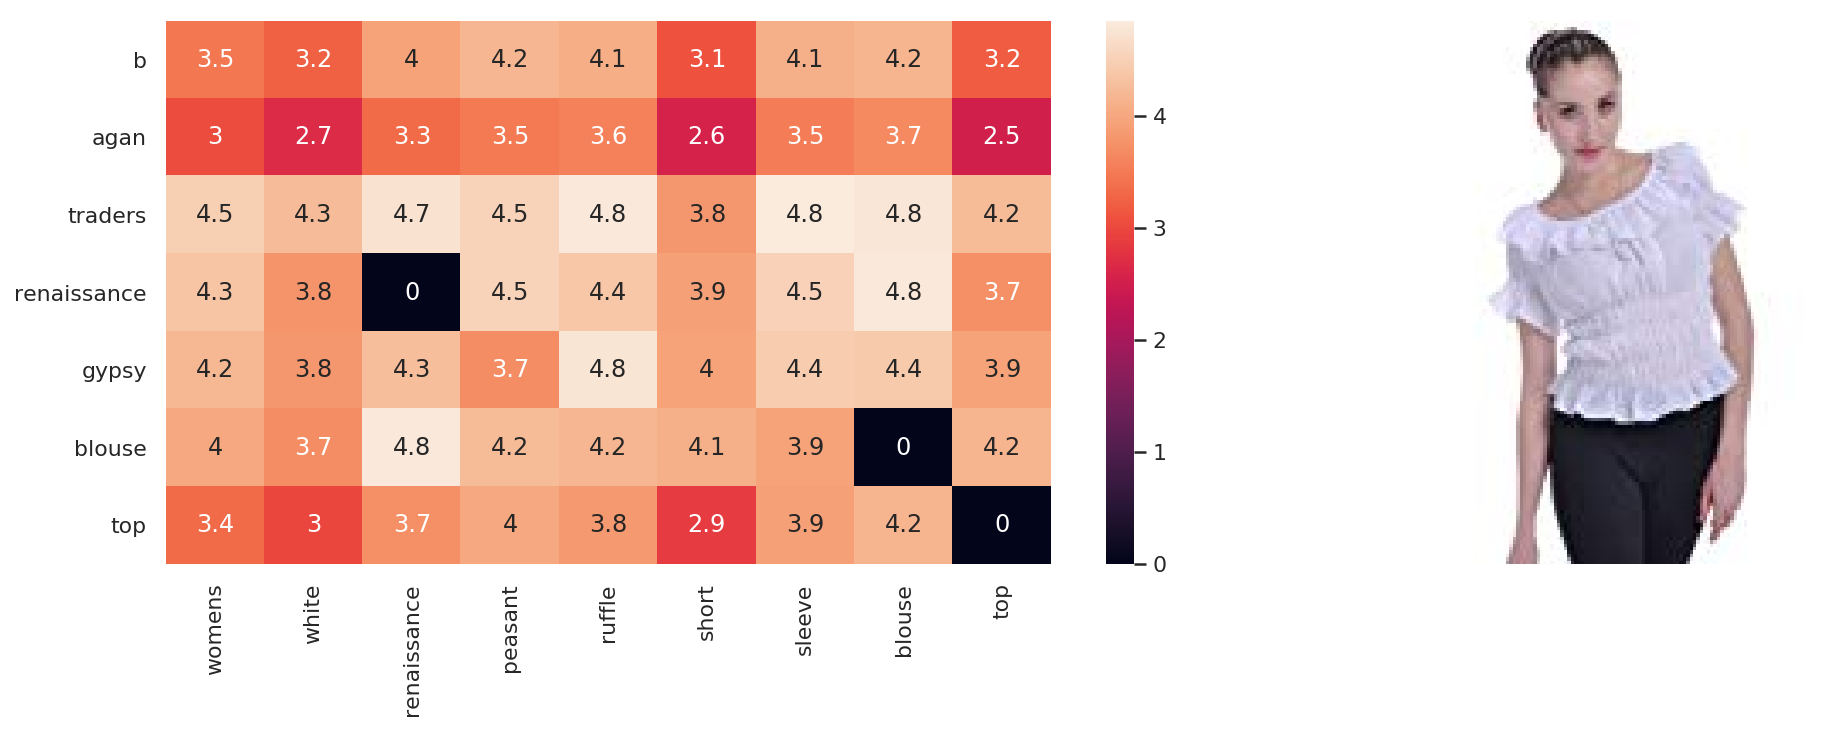

ASIN:              B0759L22PR
Title:             anna-kaci womens white renaissance peasant ruffle short sleeve blouse top
Brand:             Anna-Kaci
Minimum Distance   0.0
Maximum Distance   4.105691741304686


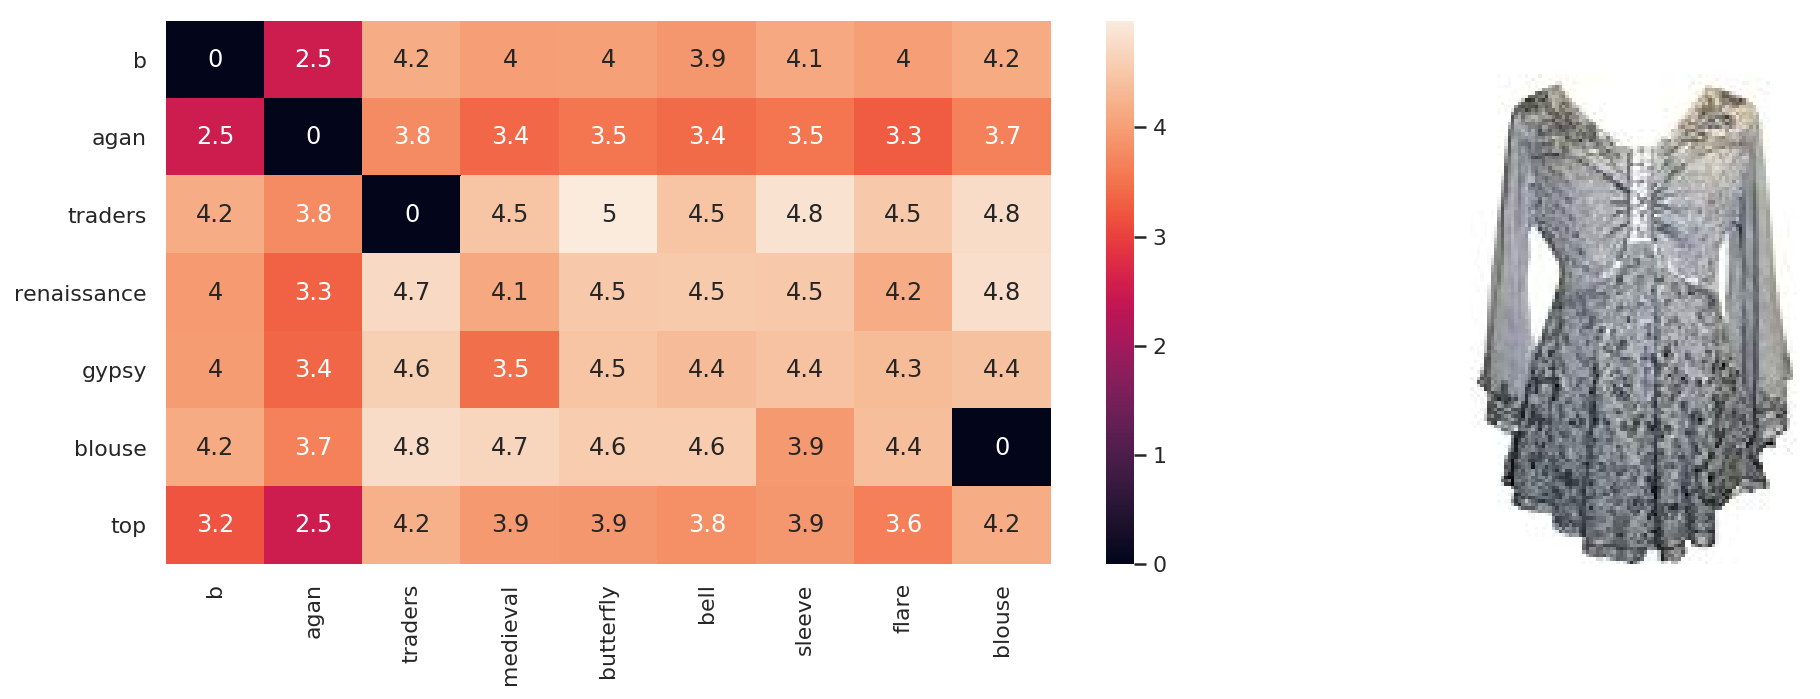

ASIN:              B00Q0YTAN8
Title:             116 b agan traders medieval butterfly bell sleeve flare blouse
Brand:             Agan Traders
Minimum Distance   0.0
Maximum Distance   3.774424682318788


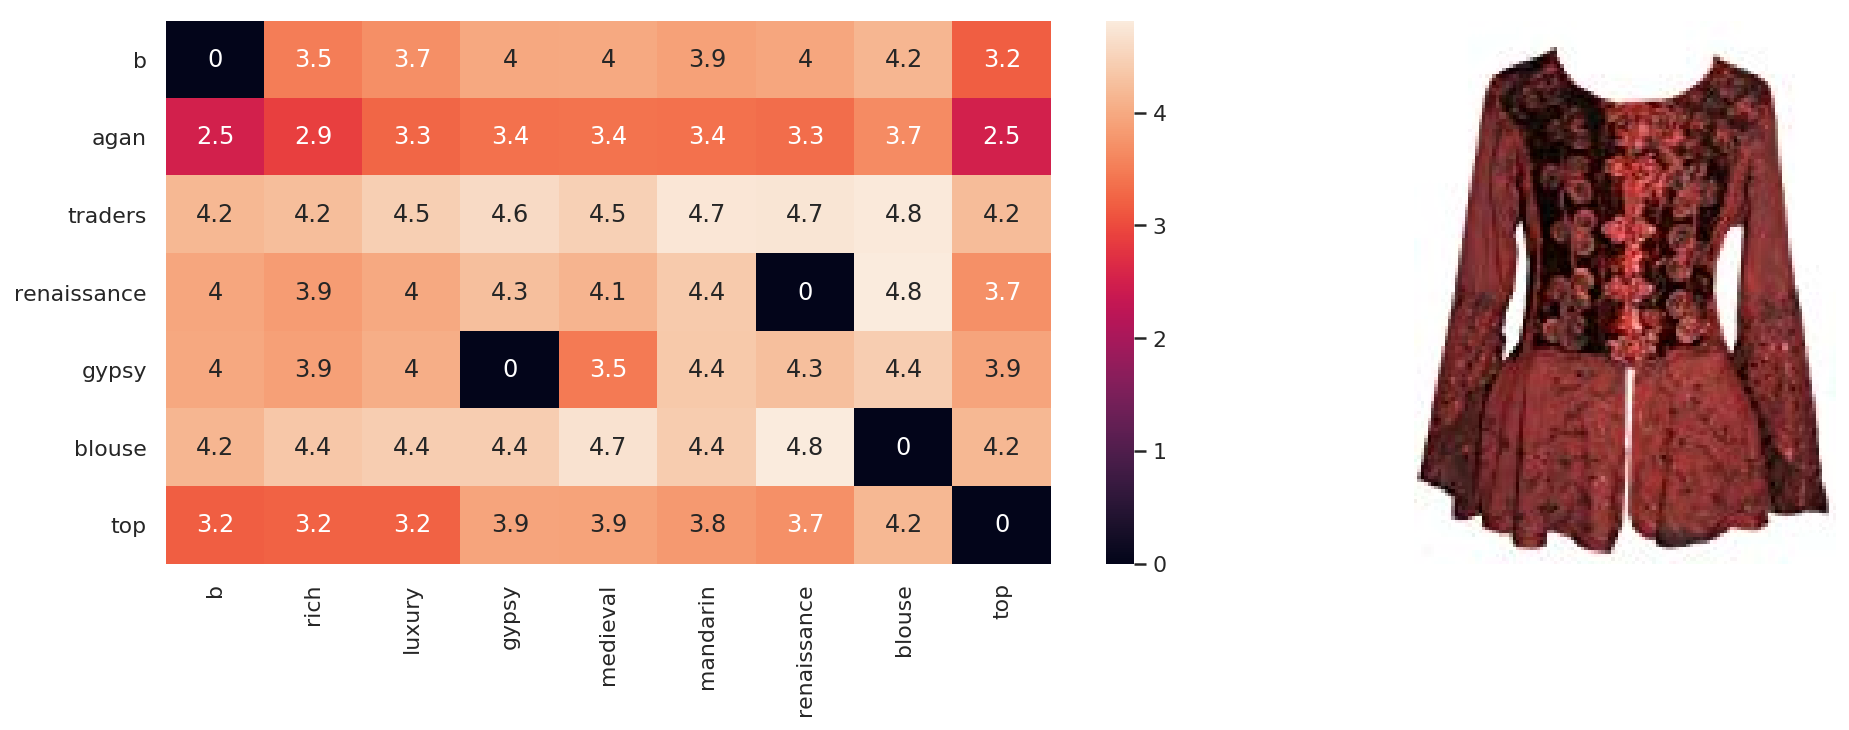

ASIN:              B007MUMT64
Title:             503 b rich luxury gypsy medieval mandarin renaissance blouse top
Brand:             Agan Traders
Minimum Distance   0.0
Maximum Distance   4.175418835756518


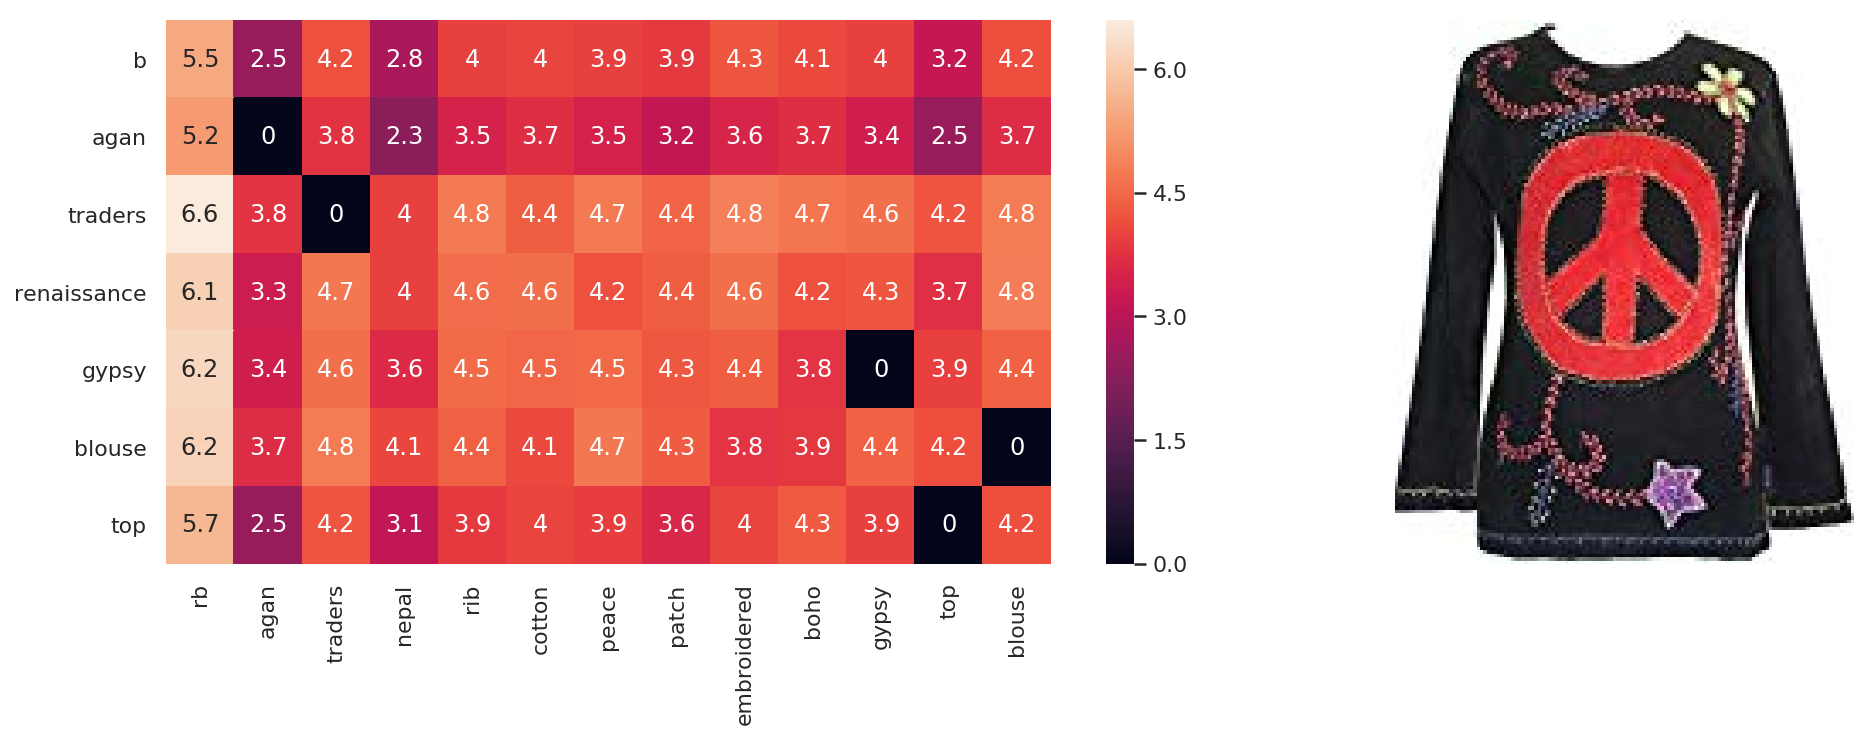

ASIN:              B01MY3JL1B
Title:             265 rb agan traders nepal rib cotton peace patch embroidered boho gypsy top blouse
Brand:             Agan Traders
Minimum Distance   0.0
Maximum Distance   3.774424682318788


In [152]:
get_n_similar_products(20, 'B00QOOK754', debug=True)

## Build VGG16 transfer learning model from images

In [518]:
!mkdir images

In [519]:
def save_image(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img.save('./images/{}'.format(url.split('/')[-1]))

In [520]:
URLS = DSample_w2v.medium_image_url.values.tolist()

In [521]:
%%time
pool = ThreadPool(8)
pool.map(save_image, URLS)
pool.close()
pool.join()

CPU times: user 4min 39s, sys: 12.1 s, total: 4min 51s
Wall time: 6min 23s


In [530]:
!ls -1 images/ | wc -l   # Some images URLs are repeated

23835


In [531]:
!gpustat

instance-gpu  Sun Jan 27 19:43:51 2019
[0] Tesla P100-PCIE-16GB | 33'C,   0 % |     0 / 16280 MB |


In [533]:
from keras.preprocessing.image import ImageDataGenerator
from keras import applications

In [537]:
!mkdir images/images2

In [538]:
!mv images/*.jpg images/images2/

In [539]:
!ls images/

images2


In [540]:
img_width, img_height = 224, 224
batch_size = 1
epochs = 50
nb_train_samples = 23835
train_data_dir = './images/'
top_model_weights_path = 'bottleneck_fc_model.h5'

asins = []
datagen = ImageDataGenerator(rescale=1. / 255)
model = applications.VGG16(include_top=False, weights='imagenet')
generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

Found 23835 images belonging to 1 classes.


In [545]:
fileNames = []
for i in generator.filenames:
    fileNames.append(i.split('/')[1])

In [548]:
%%time
bottleneck_features_train = model.predict_generator(generator, nb_train_samples // batch_size)
bottleneck_features_train = bottleneck_features_train.reshape((nb_train_samples, 25088))

CPU times: user 6min 43s, sys: 38.5 s, total: 7min 22s
Wall time: 2min 10s


In [549]:
bottleneck_features_train.shape

(23835, 25088)

In [550]:
np.save(open('16k_data_cnn_features.npy', 'wb'), bottleneck_features_train)
np.save(open('16k_data_cnn_feature_asins.npy', 'wb'), np.array(fileNames))

In [3]:
bottleneck_features_train = np.load('16k_data_cnn_features.npy')
fileNames = np.load('16k_data_cnn_feature_asins.npy')

In [4]:
fileNames = list(fileNames)

In [5]:
DSample_w2v = pd.read_csv('DSample_w2v.csv')

In [10]:
DSample_w2v['image_file'] = DSample_w2v.medium_image_url.apply(lambda x: x.split('/')[-1])

In [11]:
DSample_w2v.shape

(23835, 4317)

In [12]:
DSample_w2v = DSample_w2v[DSample_w2v.image_file.isin(fileNames)]

In [13]:
DSample_w2v.shape

(23835, 4317)

In [14]:
len(fileNames)

23835

In [10]:
DSample_w2v.sort_values('medium_image_url', inplace=True)

In [11]:
DSample_w2v.drop_duplicates(subset='medium_image_url', inplace=True)

In [12]:
DSample_w2v.shape

(23835, 4316)

In [39]:
DSample_w2v = DSample_w2v[DSample_w2v.image_file == fileNames]

In [19]:
DSample_w2v.set_index('asin', inplace=True)

In [20]:
w2v_values = DSample_w2v.iloc[:, 4:304].values
asins = DSample_w2v.index.values

In [21]:
brand_n_color_vec = DSample_w2v.iloc[:, 304:-1].values

In [22]:
brand_n_color_vec = np.nan_to_num(brand_n_color_vec)

In [23]:
brand_n_color_vec.shape

(23835, 4011)

In [24]:
def get_n_similar_products(n, asin_code, *weights, **kwargs):
    """
    Get top n similar products of the asin code 
    """
    if n % 2 != 0:
        raise ValueError('Please pass n multiple of 2')

    debug = kwargs.get('debug', False)
    ############# Product Similarity using title #############
    idf_w2v_dist = pairwise_distances(w2v_values, 
                                      w2v_values[np.where(asins == 
                                                          asin_code)[0][0]].reshape(1,-1))
    
    ############# Product Similarity using Images ############
    img_vec_dist = pairwise_distances(bottleneck_features_train, )
    img_file = DSample_w2v.loc[asin_code].image_file
    img_indx = fileNames.index(img_file)
    img_vec_dist = pairwise_distances(bottleneck_features_train, bottleneck_features_train[img_indx].reshape(1, -1))
    
    ############ Product Similarity using Brand, Color ##########
    brand_n_color_dist = pairwise_distances(brand_n_color_vec, 
                                      brand_n_color_vec[np.where(asins == 
                                                          asin_code)[0][0]].reshape(1,-1), n_jobs=-1)
    
    pairwise_dist   = (weights[0] * idf_w2v_dist +  
                       weights[1] * img_vec_dist + 
                       weights[2] * brand_n_color_dist)/float(sum(weights))
    
    
    similar_products = asins[np.argsort(pairwise_dist.flatten())][0:n+1]
    imgs = DSample_w2v.loc[similar_products].medium_image_url.values
    

    if not debug:
        display_images(n, imgs)
    else:
        table = get_word_vector(DSample_w2v.loc[asin_code].title)
        display_images_with_details(table, similar_products)

In [27]:
model = KeyedVectors.load_word2vec_format('/home/mayukhpay/GoogleNews-vectors-negative300.bin',
                                         binary=True)

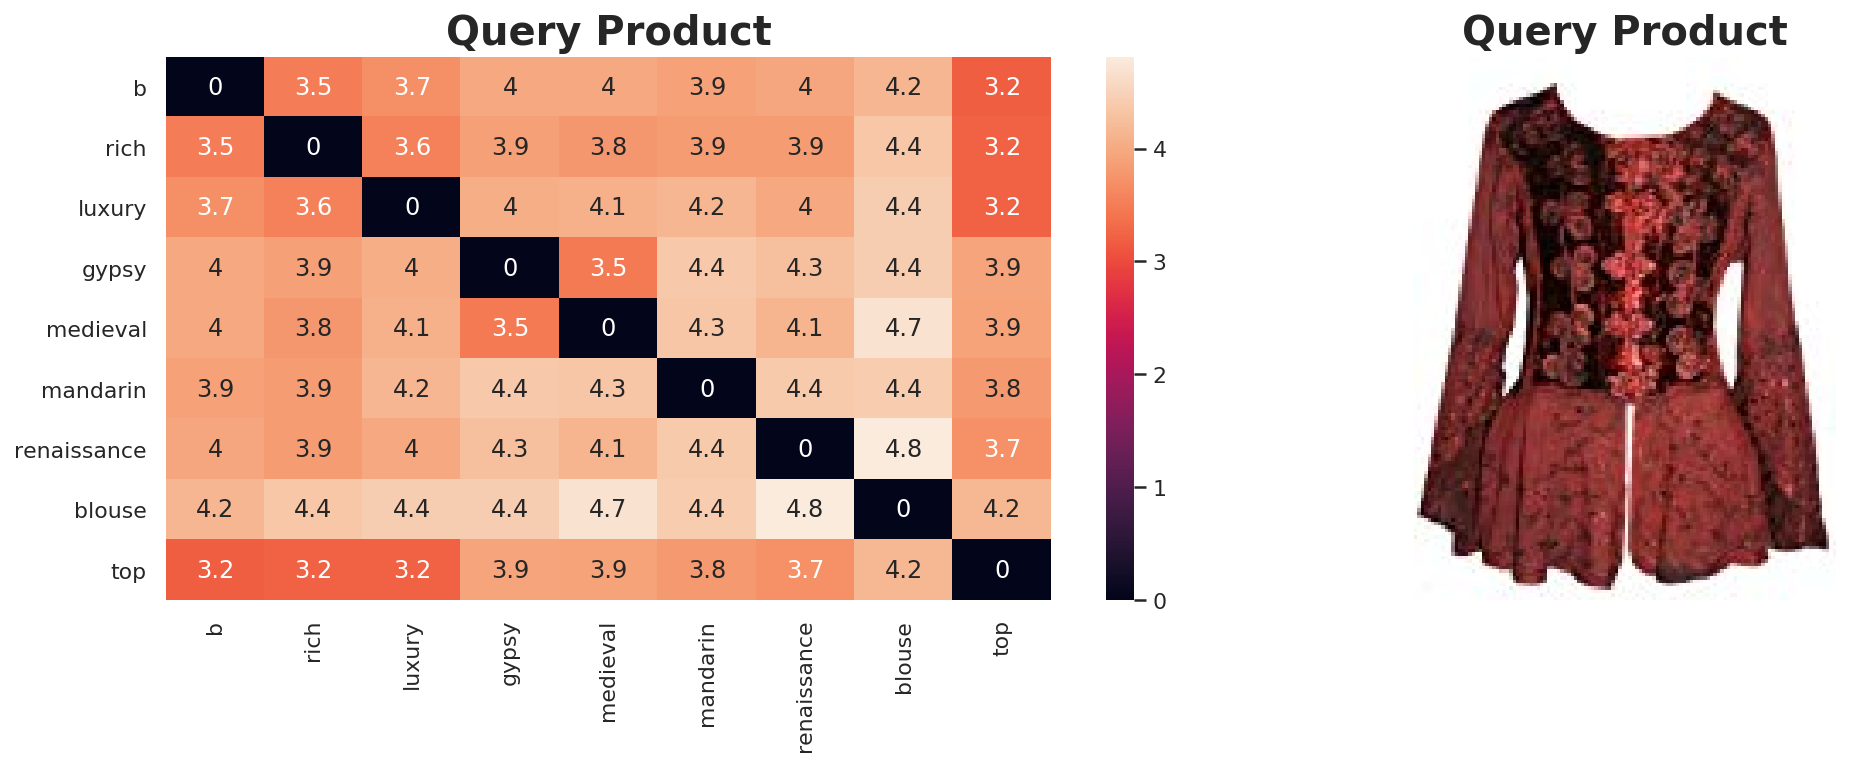

__________________________________________________________________________________________________________________________________


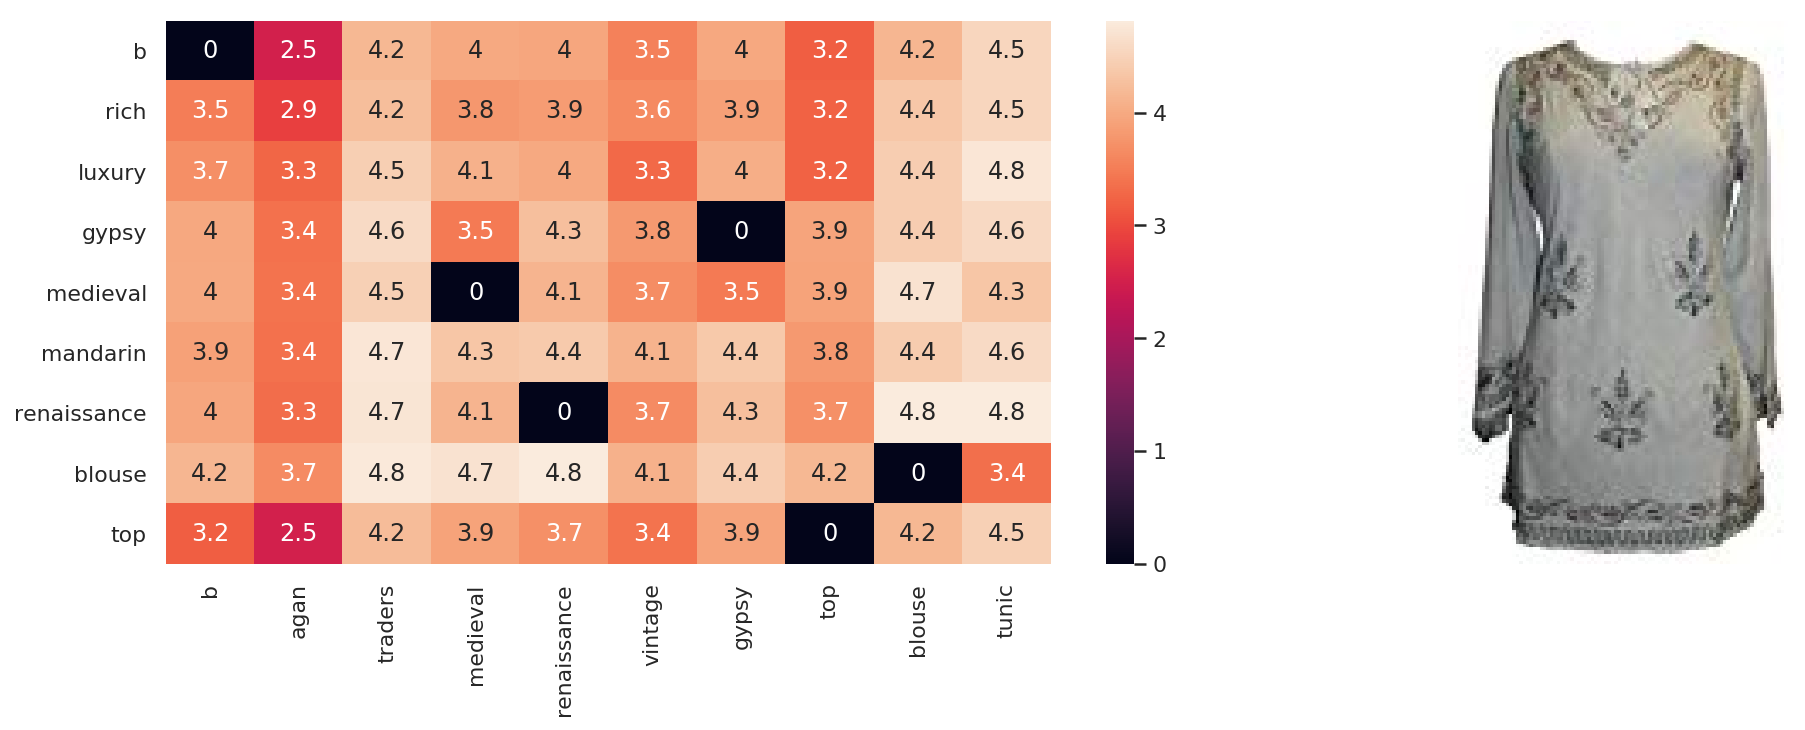

ASIN:              B00CAFYNAG
Title:             117 b agan traders medieval renaissance vintage gypsy top blouse tunic
Brand:             Agan Traders
Minimum Distance   0.0
Maximum Distance   3.664824816439256


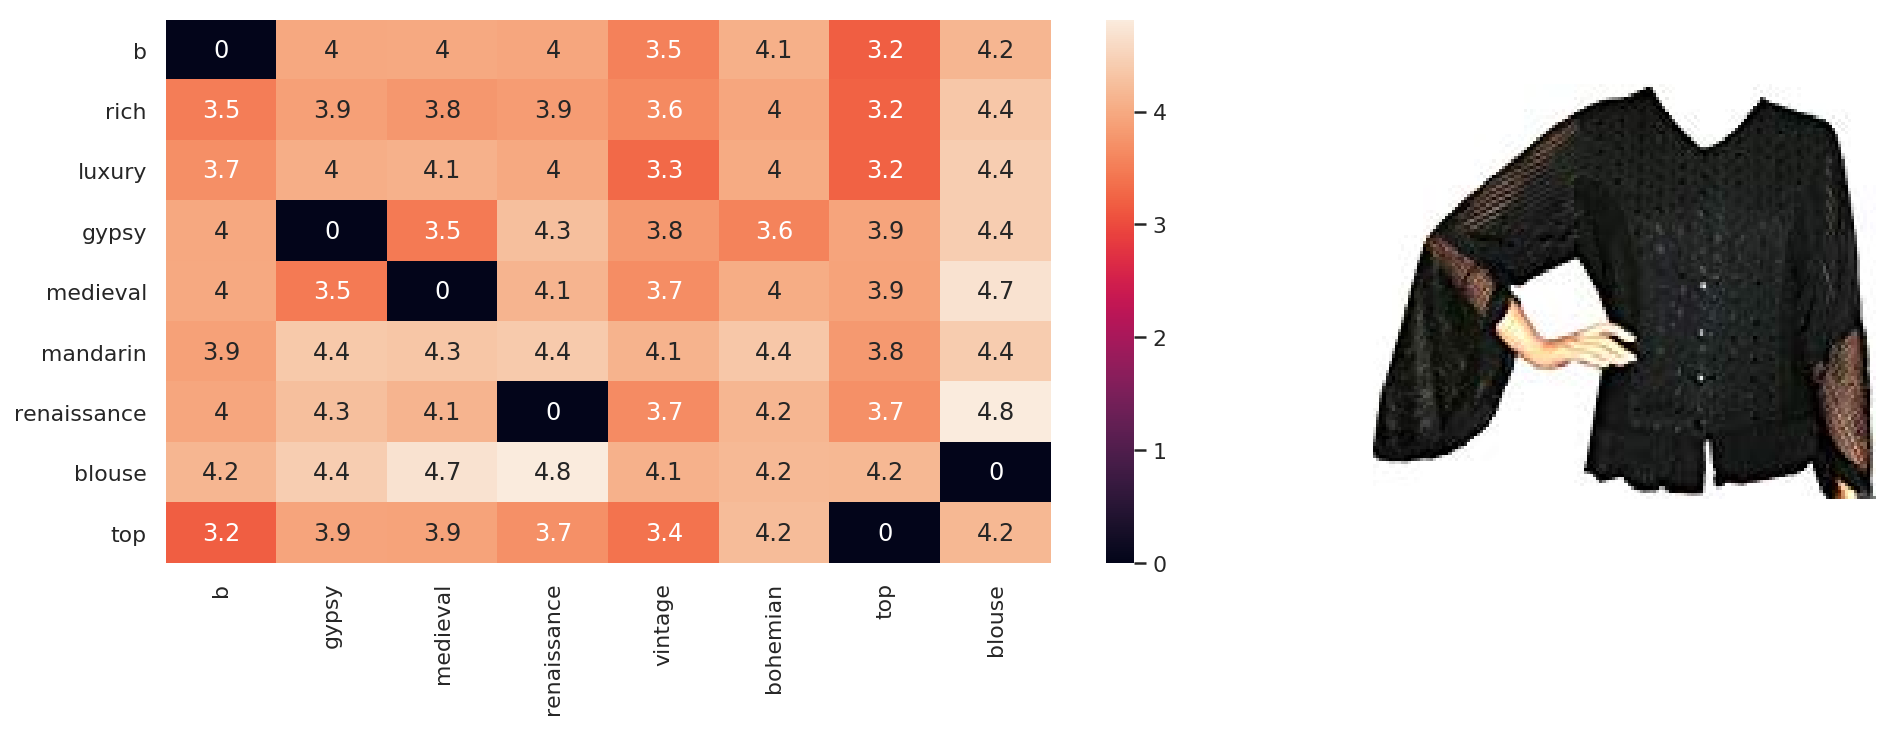

ASIN:              B00CAD7VVQ
Title:             103 b gypsy medieval renaissance vintage bohemian top blouse
Brand:             Agan Traders
Minimum Distance   0.0
Maximum Distance   4.1128500463785675


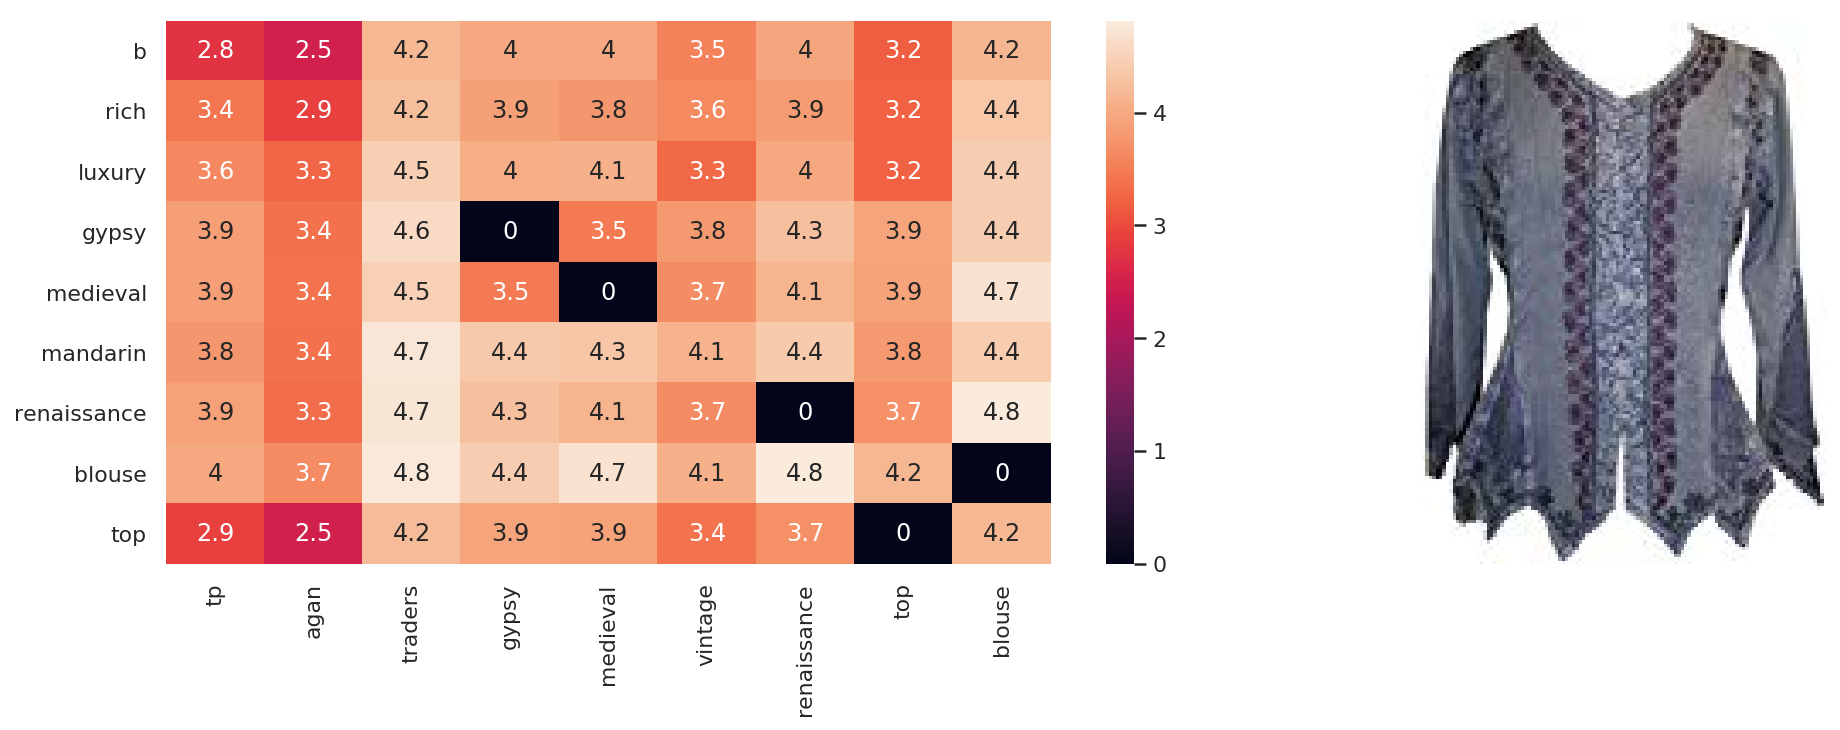

ASIN:              B00LY8AG24
Title:             107 tp agan traders gypsy medieval vintage renaissance top blouse
Brand:             Agan Traders
Minimum Distance   0.0
Maximum Distance   3.664824816439256


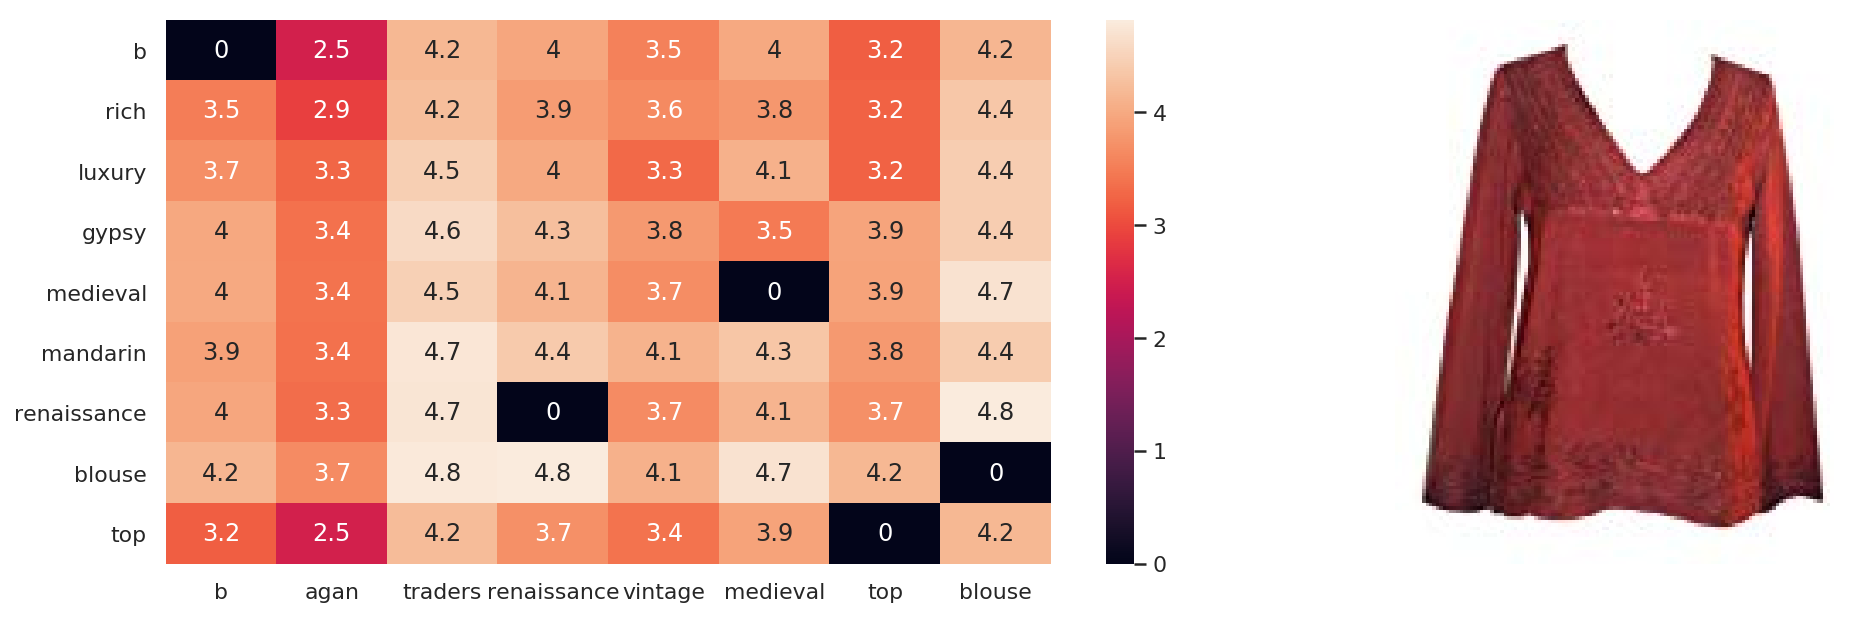

ASIN:              B00G4E1QYU
Title:             112 b agan traders renaissance vintage medieval top blouse
Brand:             Agan Traders
Minimum Distance   0.0
Maximum Distance   3.664824816439256


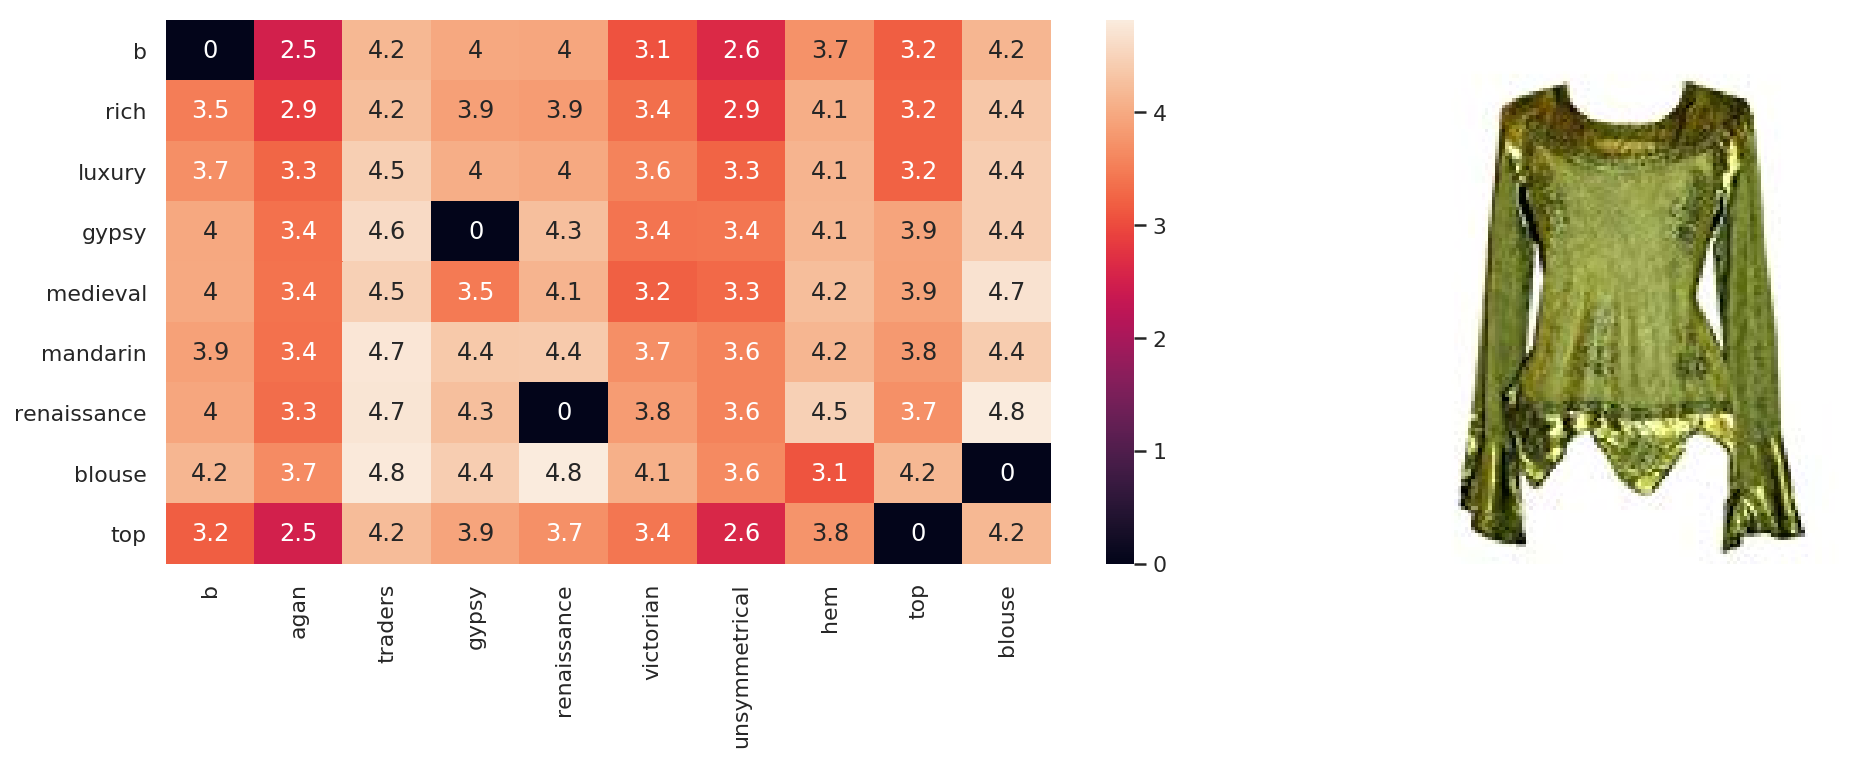

ASIN:              B007JWE1D4
Title:             106 b agan traders gypsy renaissance victorian unsymmetrical hem top blouse
Brand:             Agan Traders
Minimum Distance   0.0
Maximum Distance   3.635619007971239


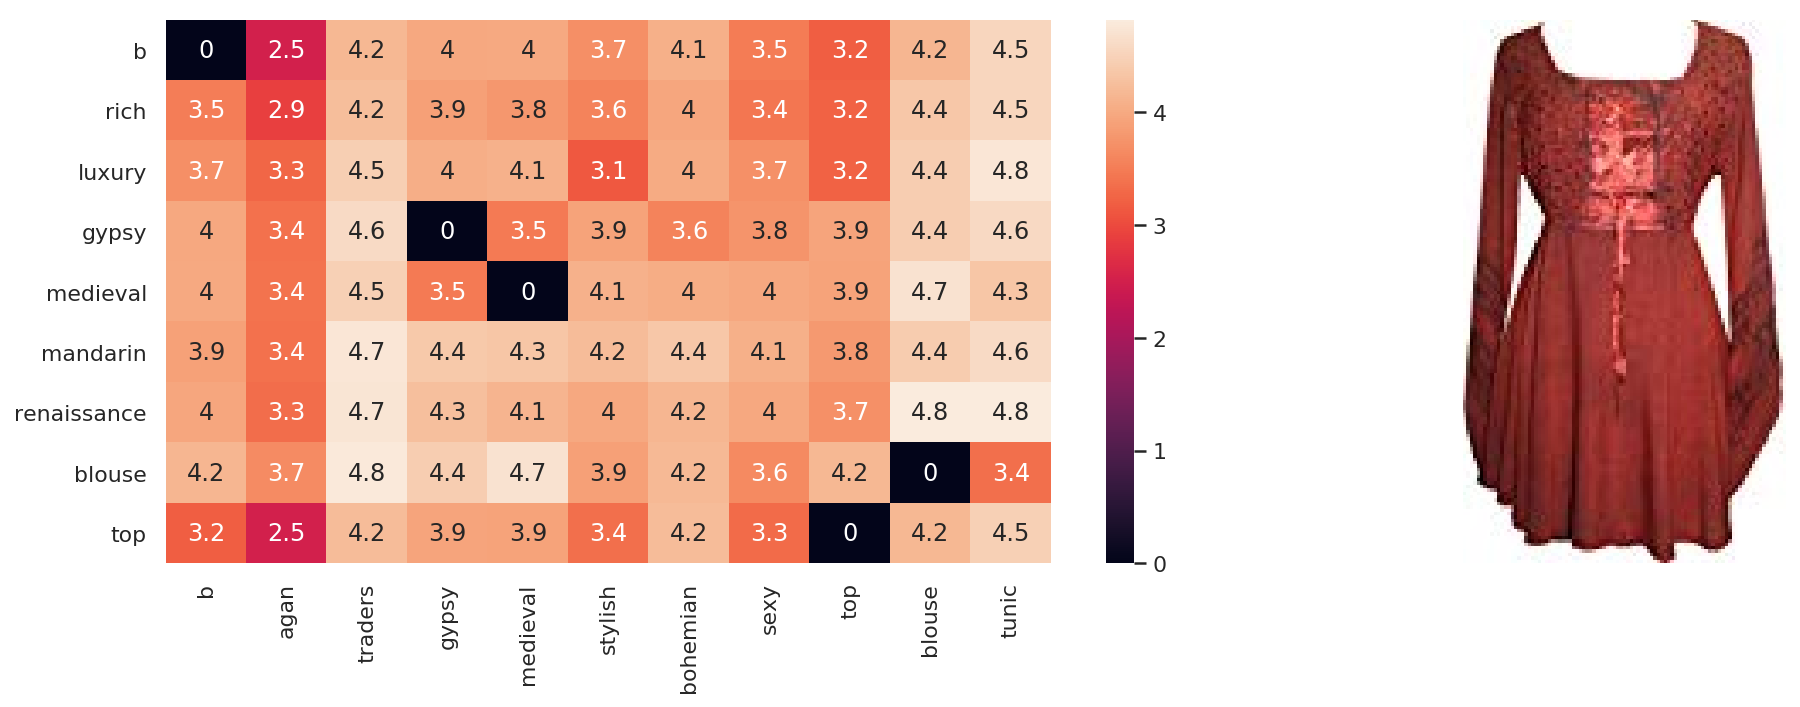

ASIN:              B00G4DCFV4
Title:             11 b agan traders gypsy medieval stylish bohemian sexy top blouse tunic
Brand:             Agan Traders
Minimum Distance   0.0
Maximum Distance   3.664824816439256


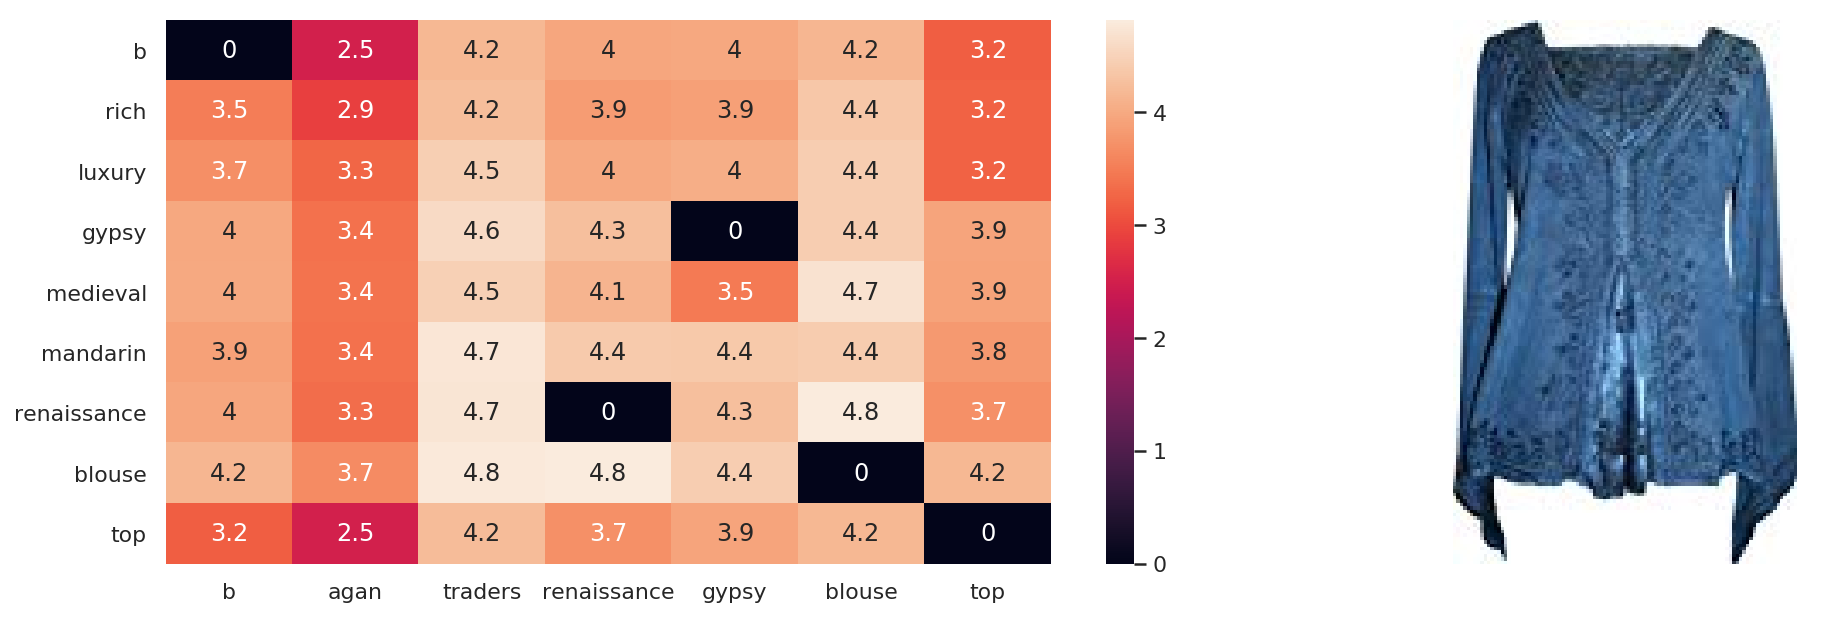

ASIN:              B00QOOK754
Title:             01 b agan traders renaissance gypsy blouse top
Brand:             Agan Traders
Minimum Distance   0.0
Maximum Distance   3.664824816439256


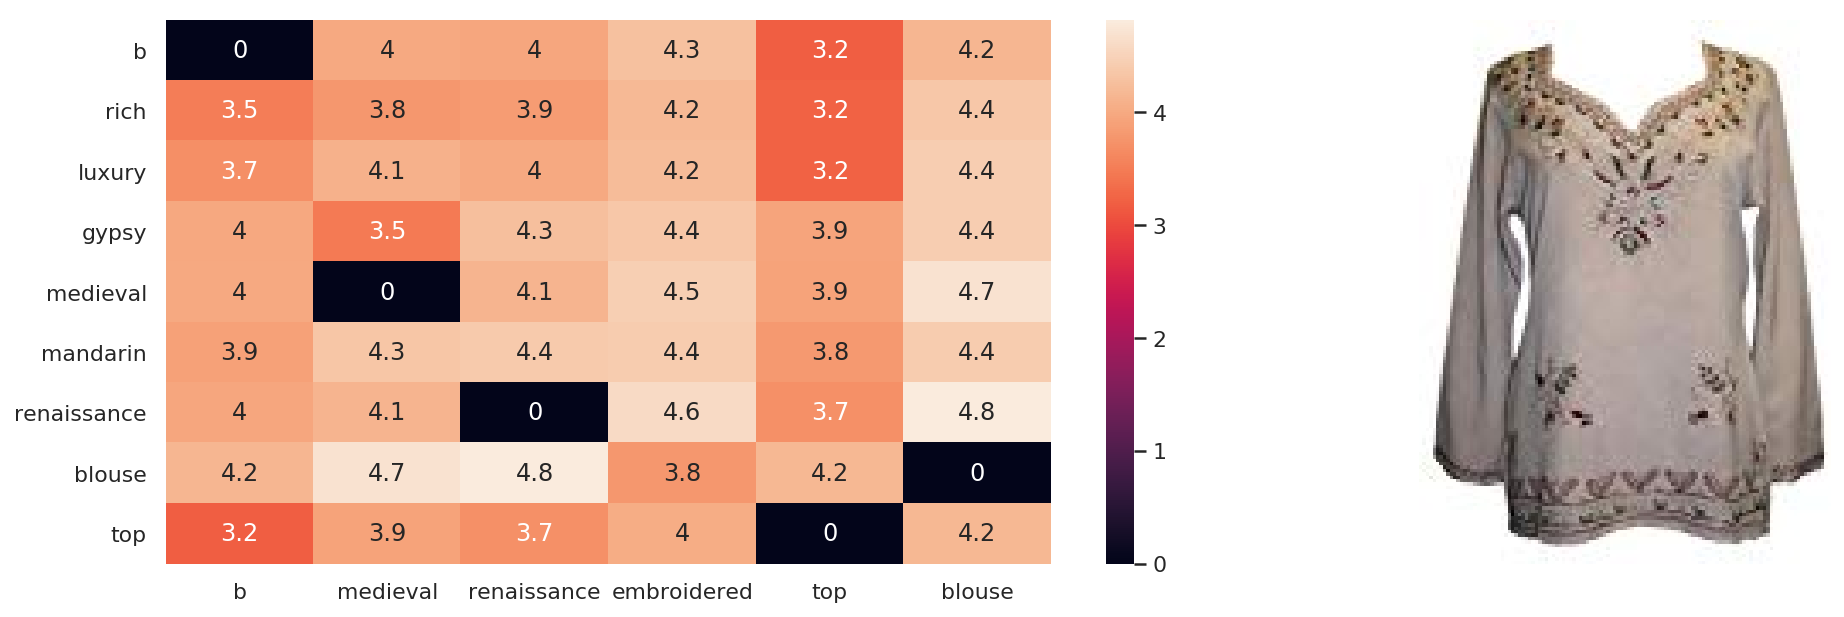

ASIN:              B00AHXIC96
Title:             720 b medieval renaissance embroidered top blouse
Brand:             Agan Traders
Minimum Distance   0.0
Maximum Distance   4.155924809476894


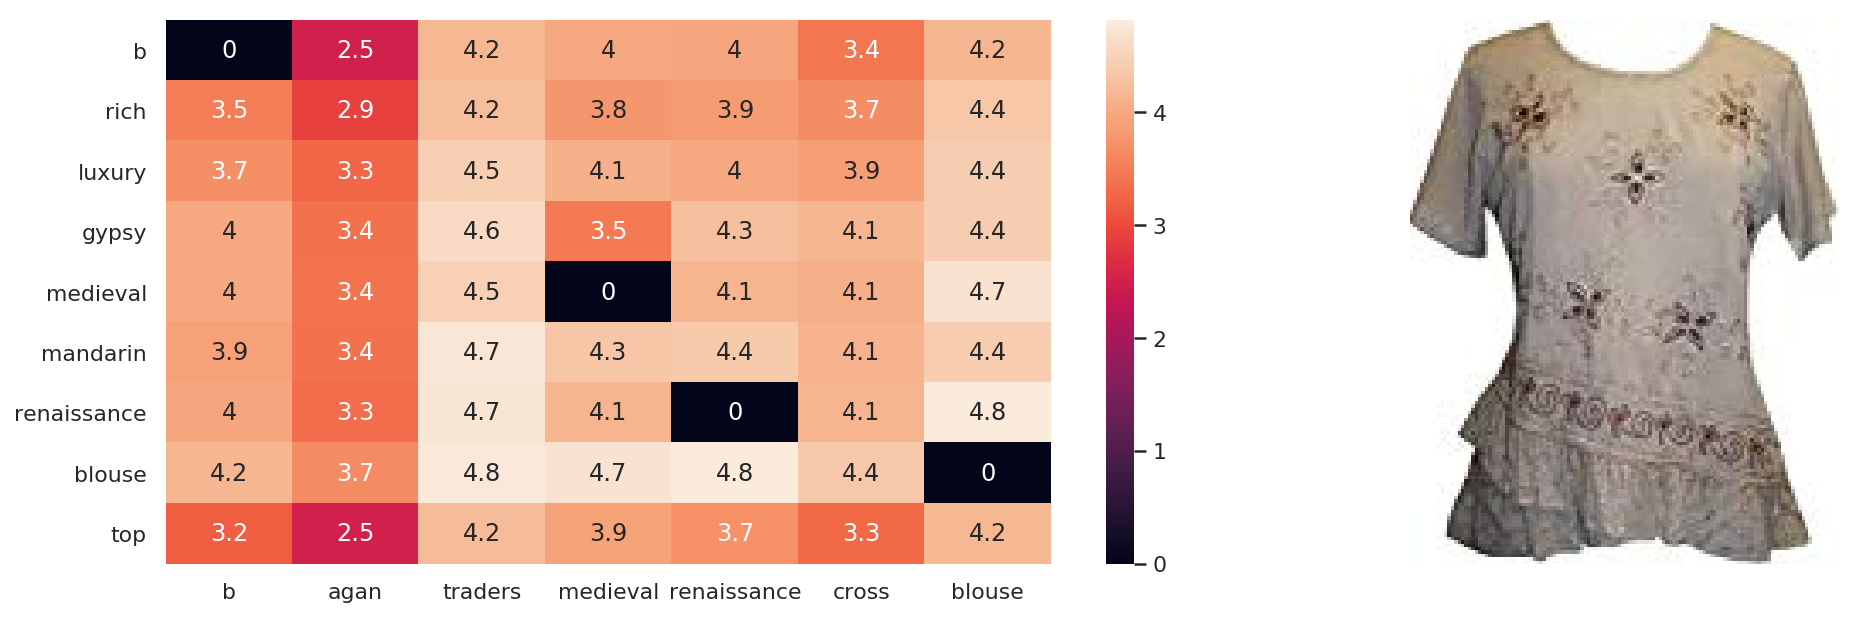

ASIN:              B00CMWL56M
Title:             118 b agan traders medieval renaissance cross blouse
Brand:             Agan Traders
Minimum Distance   0.0
Maximum Distance   3.664824816439256


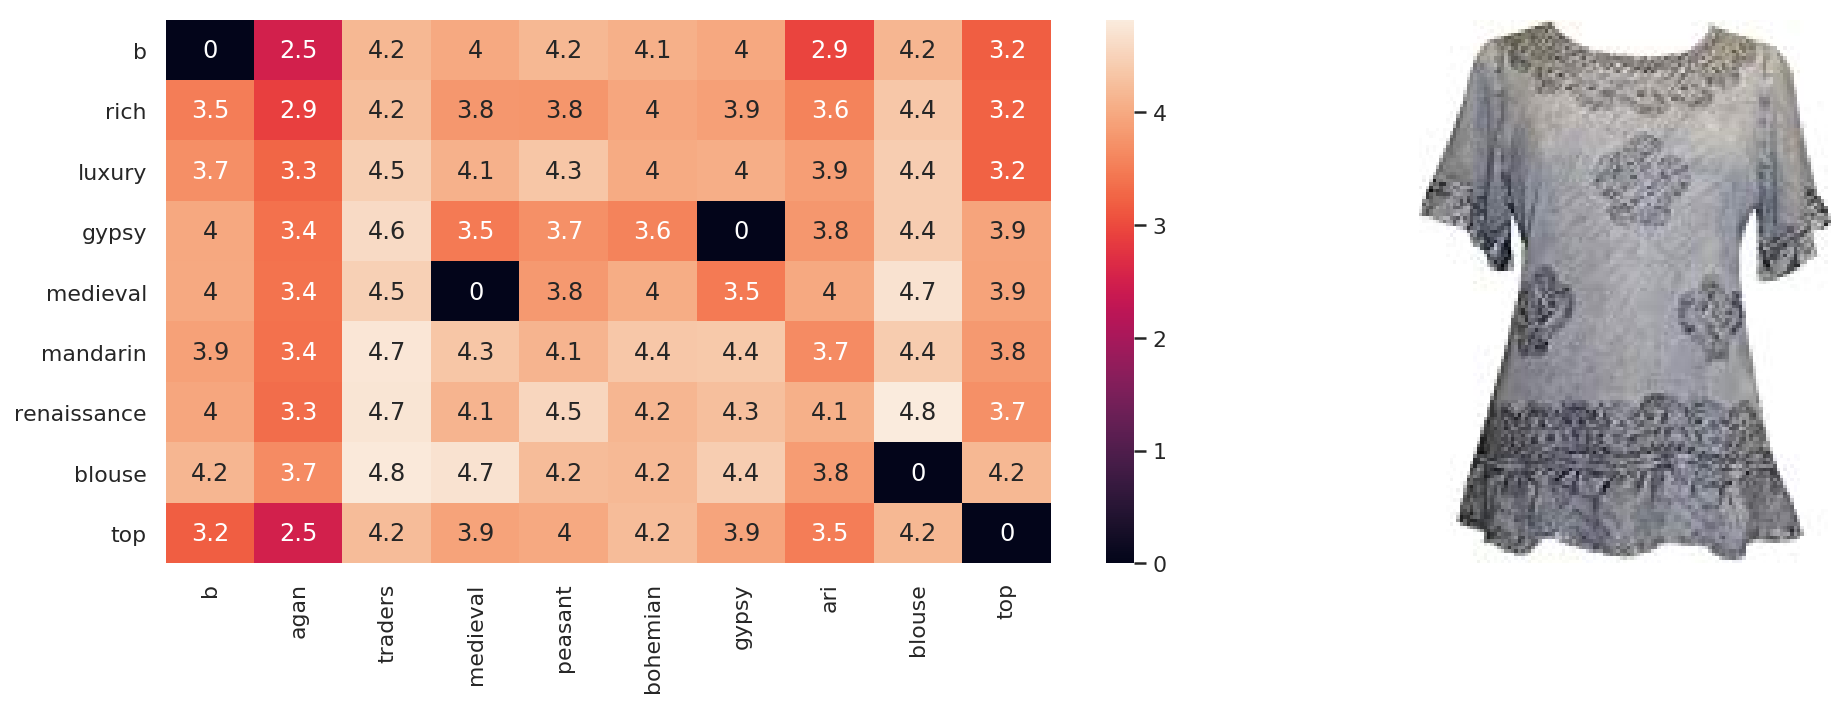

ASIN:              B01G7KE9SK
Title:             142 b agan traders medieval peasant bohemian gypsy ari blouse top
Brand:             Agan Traders
Minimum Distance   0.0
Maximum Distance   3.664824816439256


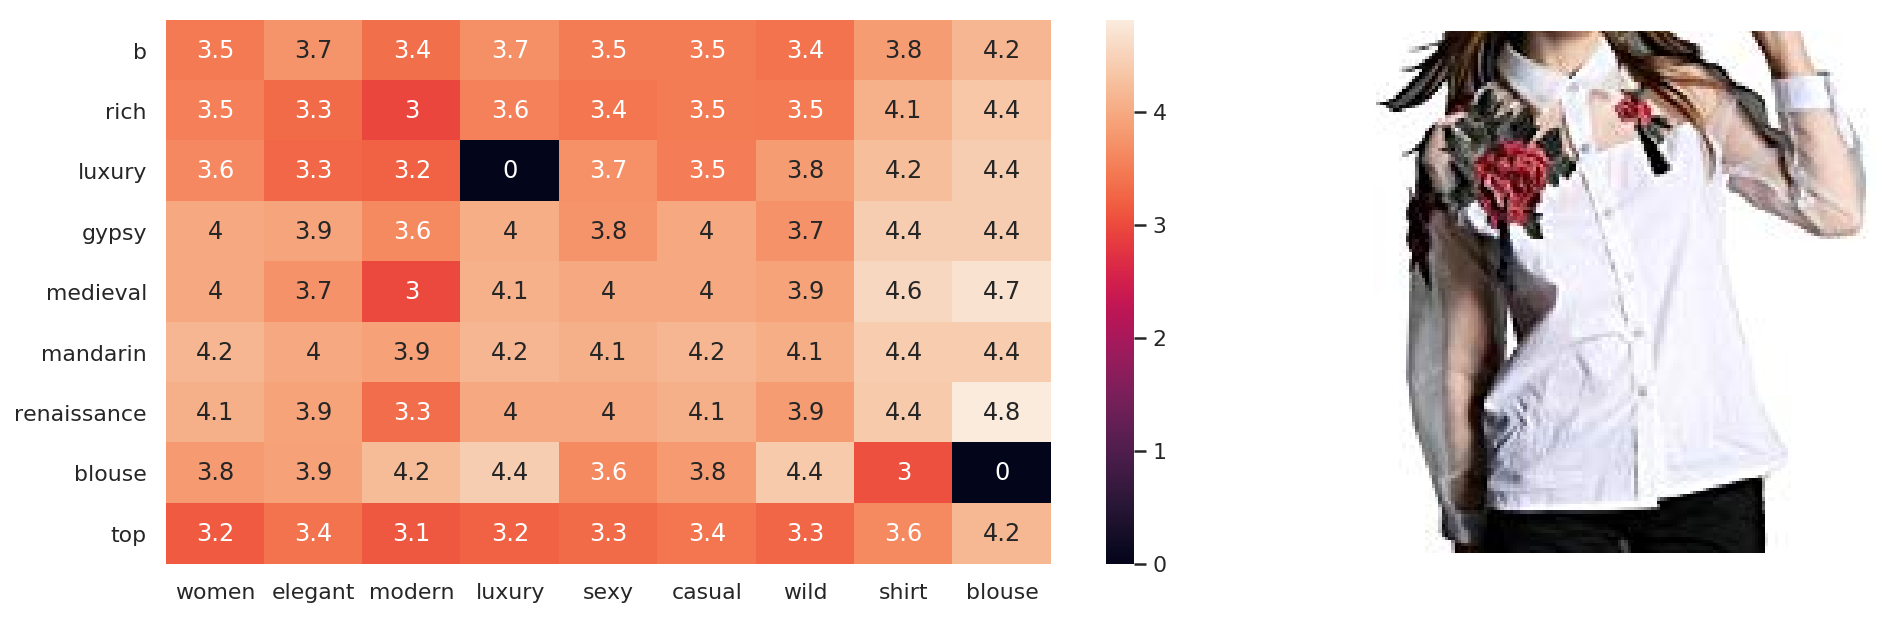

ASIN:              B06WGXQQ7S
Title:             coolred women elegant modern luxury sexy casual wild shirt blouse
Brand:             Coolred-Women
Minimum Distance   0.0
Maximum Distance   3.9894233186325567


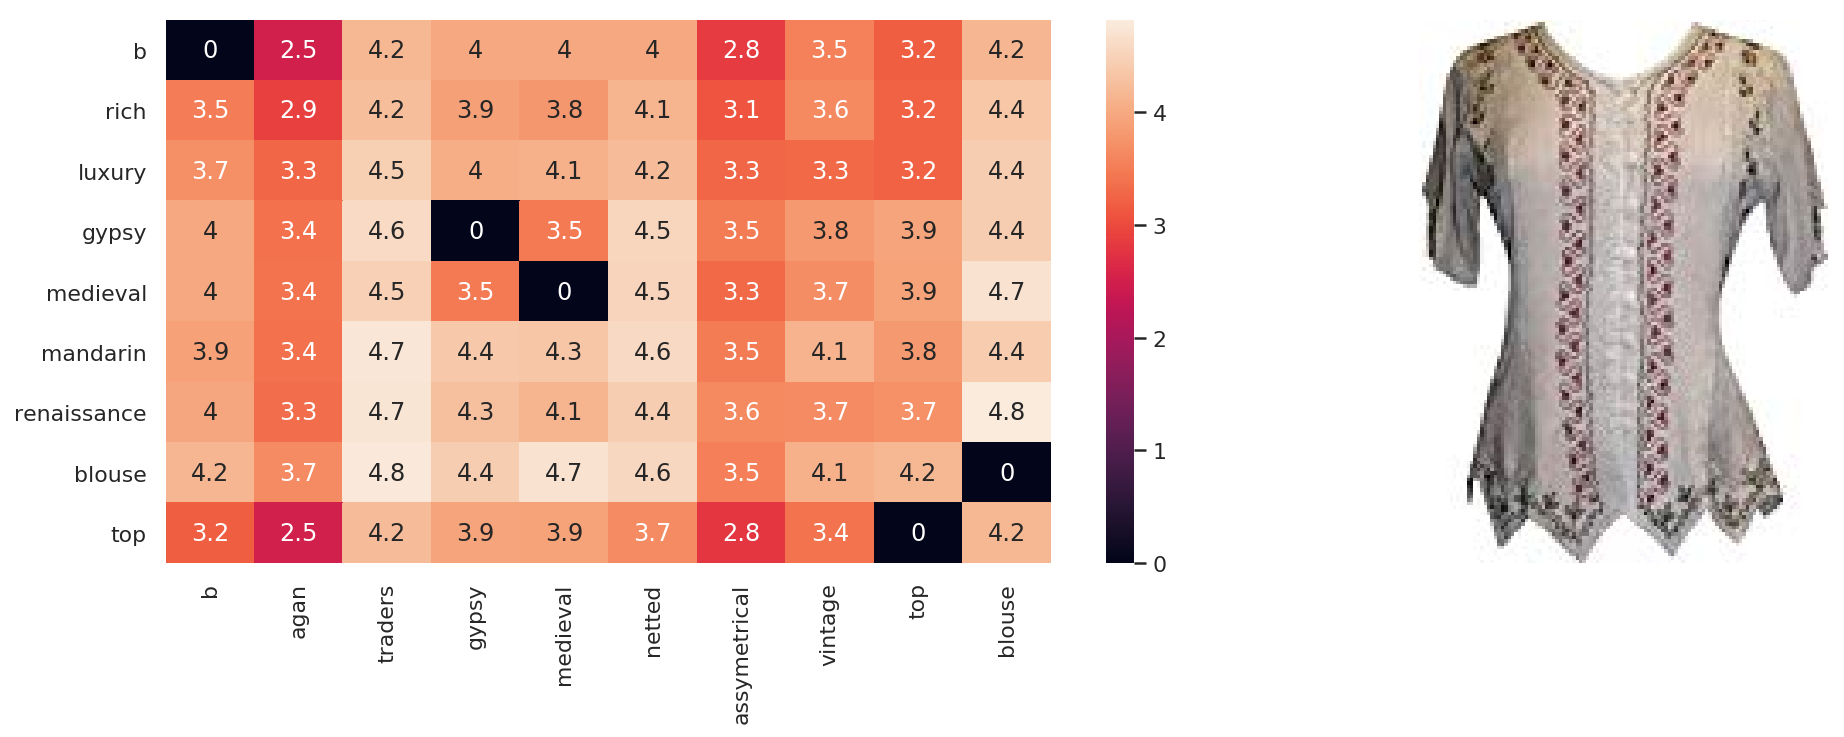

ASIN:              B0145PTI08
Title:             136 b agan traders gypsy medieval netted assymetrical vintage top blouse
Brand:             Agan Traders
Minimum Distance   0.0
Maximum Distance   3.6441784930227215


In [31]:
get_n_similar_products(12, 'B007MUMT64', 0.8, 0.0, 0.0, debug=True)